# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData, augmentReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1757299702.847896 3257323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757299702.854743 3257323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757299702.872550 3257323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757299702.872568 3257323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757299702.872570 3257323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757299702.872571 3257323 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

# CMAQ DATA

## Load dataset

### Raw data

In [4]:
df_cmaq_raw = []
for csv_file in glob.glob(f'{conf["dataset"]["cmaq"]["file_dir"]}/*'):
    df_current_station = pd.read_csv(csv_file).dropna(axis=1, how="all")
    station = csv_file.split("/")[-1].split(".")[0]
    print(f"{csv_file} - {len(df_current_station)} records")
    df_current_station["station"] = station
    df_cmaq_raw.append(df_current_station)
df_cmaq_raw = pd.concat(df_cmaq_raw, axis=0, ignore_index=True)
df_cmaq_raw

/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/216.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/212.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/201.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/215.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/213.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/214.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/211.csv - 7476 records


Date      Time       PM25       PM10        O3       SO2  \
0      01/01/2022   7:00:00   4.962867  17.781220  0.098060  0.000077   
1      01/01/2022   8:00:00   6.538577  23.655580  0.079992  0.000105   
2      01/01/2022   9:00:00   7.173492  25.594369  0.063973  0.000132   
3      01/01/2022  10:00:00   7.377719  26.746649  0.052615  0.000131   
4      01/01/2022  11:00:00   6.629785  23.692133  0.044166  0.000090   
...           ...       ...        ...        ...       ...       ...   
52327  31/12/2022   1:00:00  12.338016  44.975750  0.027149  0.000055   
52328  31/12/2022   2:00:00  12.207455  43.493079  0.026779  0.000055   
52329  31/12/2022   3:00:00  12.345228  45.676369  0.026994  0.000056   
52330  31/12/2022   4:00:00  12.455814  47.065511  0.026826  0.000057   
52331  31/12/2022   5:00:00  12.337399  44.779930  0.026044  0.000057   

            NO2 station  
0      0.000981     216  
1      0.001294     216  
2      0.001035     216  
3      0.000818     216  
4      0.000607     216  
...         ...     ...  
52327  0.000068     211  
52328  0.000067     211  
52329  0.000067     211  
52330  0.000067     211  
52331  0.000066     211  

[52332 rows x 8 columns]

### Handle metadata

In [5]:
# Merge Date and Time columns
df_cmaq_raw["time"] = df_cmaq_raw["Time"] + " " + df_cmaq_raw["Date"]
df_cmaq_raw["time"] = df_cmaq_raw["time"].apply(lambda element: datetime.strptime(element, "%H:%M:%S %d/%m/%Y"))
df_cmaq_raw = df_cmaq_raw.assign(time=pd.to_datetime(df_cmaq_raw["time"]))
df_cmaq_raw = df_cmaq_raw.assign(station=df_cmaq_raw["station"].astype("int64"))
df_cmaq_raw.drop(columns=["Date", "Time"], inplace=True)

# Rename columns
df_cmaq_raw = df_cmaq_raw.rename(columns={name: f"{name.lower()}" for name in df_cmaq_raw.columns})

# Sort data by "station" then "time"
df_cmaq_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_cmaq_raw.set_index("time", inplace=True)

# Print
df_cmaq_raw

pm25       pm10        o3       so2       no2  \
time                                                                      
2022-01-01 07:00:00   8.070718  28.069728  0.098301  0.000047  0.001115   
2022-01-01 08:00:00   9.922100  35.973360  0.078072  0.000062  0.001141   
2022-01-01 09:00:00  11.191617  40.858557  0.061198  0.000082  0.000941   
2022-01-01 10:00:00  11.655973  43.331055  0.050983  0.000087  0.000761   
2022-01-01 11:00:00  11.074831  39.380184  0.042117  0.000068  0.000600   
...                        ...        ...       ...       ...       ...   
2022-12-31 01:00:00   9.481827  34.121409  0.026421  0.000149  0.002276   
2022-12-31 02:00:00   9.389163  34.542116  0.026171  0.000148  0.002208   
2022-12-31 03:00:00   9.472814  34.649932  0.026087  0.000151  0.002249   
2022-12-31 04:00:00  10.222586  36.111460  0.026347  0.000166  0.002680   
2022-12-31 05:00:00  10.196095  36.470190  0.026102  0.000164  0.002590   

                     station  
time                          
2022-01-01 07:00:00      201  
2022-01-01 08:00:00      201  
2022-01-01 09:00:00      201  
2022-01-01 10:00:00      201  
2022-01-01 11:00:00      201  
...                      ...  
2022-12-31 01:00:00      216  
2022-12-31 02:00:00      216  
2022-12-31 03:00:00      216  
2022-12-31 04:00:00      216  
2022-12-31 05:00:00      216  

[52332 rows x 6 columns]

In [6]:
df_cmaq_raw.isnull().sum()

pm25       0
pm10       0
o3         0
so2        0
no2        0
station    0
dtype: int64

In [7]:
all_resampled_dfs = []
for station in df_cmaq_raw["station"].unique():
    df_cmaq_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]
    df_cmaq_current_station_resampled = df_cmaq_current_station.resample("D").mean()
    df_cmaq_current_station_resampled["station"] = station
    all_resampled_dfs.append(df_cmaq_current_station_resampled)

df_cmaq_daily = pd.concat(all_resampled_dfs, axis=0)
print(df_cmaq_daily["station"].unique())
df_cmaq_daily

[201 211 212 213 214 215 216]


pm25       pm10        o3       so2       no2  station
time                                                                   
2022-01-01  15.269127  48.407405  0.038950  0.000095  0.001809      201
2022-01-02  16.298580  59.344891  0.027448  0.000107  0.002403      201
2022-01-03  15.532542  56.512608  0.027952  0.000121  0.002359      201
2022-01-04  19.030452  66.483882  0.027218  0.000206  0.003297      201
2022-01-05  26.266464  82.340143  0.027566  0.000388  0.004734      201
...               ...        ...       ...       ...       ...      ...
2022-12-27  28.235250  78.640922  0.028089  0.001259  0.007881      216
2022-12-28  26.291384  77.514532  0.026661  0.000907  0.006642      216
2022-12-29  26.971063  63.326358  0.026366  0.000821  0.012799      216
2022-12-30  19.645784  52.679791  0.028655  0.000530  0.007603      216
2022-12-31   9.745557  34.890883  0.026313  0.000156  0.002431      216

[2555 rows x 6 columns]

# AOD DATA

## Load 2022 dataset

In [8]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [9]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [10]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2018-2021 dataset

In [11]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [12]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
0    2018-01-01      201  31.391304  10.783057  106.700606  34.919998   
1    2018-01-01      202  29.615625  10.762638  106.682027  32.099998   
2    2018-01-02      201  37.458333  10.783057  106.700606  51.830002   
3    2018-01-02      202  36.244792  10.762638  106.682027  44.619999   
4    2018-01-03      201  68.083333  10.783057  106.700606  38.240002   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
0     25.204139  70.056728  455.131335  2.352895  ...        6885.987305   
1     25.100436  71.060891  457.243423  2.344162  ...        7097.612305   
2     24.726431  73.425826  339.083720  1.903761  ...        6885.987305   
3     24.663358  73.870799  338.530190  1.885305  ...        7097.612305   
4     26.095087  77.793432  367.190738  1.293329  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
0     18.537305    296.311570  764977.7039     0.000000   1876.639945   
1      3.822386    395.082094  947604.4016     0.000000   2963.115702   
2     18.537305    296.311570  764977.7039     0.000000   1876.639945   
3      3.822386    395.082094  947604.4016     0.000000   2963.115702   
4     18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
0     232011.95950      0.000000  2700.122924       NaN  
1      13926.64380  35063.535810  1765.098553       NaN  
2     232011.95950      0.000000  2700.122924  1.110117  
3      13926.64380  35063.535810  1765.098553  1.277641  
4     232011.95950      0.000000  2700.122924  1.439045  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [13]:
df_aod_raw_2021["station"].unique()

array([201, 202, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [14]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[3889 rows x 21 columns]

In [15]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## EDA

In [16]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')
display(df_aod_stat.iloc[:, 0:7])
display(df_aod_stat.iloc[:, 7:14])
display(df_aod_stat.iloc[:, 14:22])

station         pm25          lat          lon     pm25_3km  \
count  3889.000000  3889.000000  3889.000000  3889.000000  3889.000000   
mean    207.520185    23.011572    10.788306   106.689282    20.046538   
std       6.563450    10.301408     0.025632     0.037486     9.668466   
min     201.000000     4.333333    10.740760   106.617000     5.440000   
25%     201.000000    15.444042    10.780482   106.659511    13.147358   
50%     202.000000    20.583333    10.783057   106.700606    17.610001   
75%     214.000000    28.387500    10.783456   106.700606    24.095436   
max     216.000000    87.416667    10.870190   106.796200    96.139999   

               tmp           rh  
count  3889.000000  3889.000000  
mean     27.486412    75.352473  
std       1.330104     8.409504  
min      21.016206    48.819080  
25%      26.632843    69.889214  
50%      27.570251    75.316635  
75%      28.413069    81.705930  
max      33.235374    94.121568

hpbl         wspd           pop  road_den_1km  \
count  3889.000000  3889.000000   3889.000000   3889.000000   
mean    581.026019     3.000106  29817.660439     27.142390   
std     147.090395     0.961473  15836.834517      4.811024   
min      63.078468     1.076171  14886.636720     18.211647   
25%     481.499541     2.329683  20680.626950     23.362053   
50%     578.328613     2.836771  20680.626950     27.462461   
75%     678.799988     3.507094  35151.593750     27.462461   
max    1367.739014     8.555794  64615.492190     37.829433   

       prim_road_len_1km    near_dist      bareland  
count        3889.000000  3889.000000   3889.000000  
mean         4713.665609    14.797250   3729.457120  
std          2633.314899    10.196835   5363.607284  
min             0.000000     2.546965    296.311570  
25%          2345.868408     6.057246    296.311570  
50%          6885.987305    18.537305    395.082094  
75%          6885.987305    18.537305  10370.904960  
max          7249.776367    49.023548  16297.136360

builtup     cropland     grassland      treecover         water  \
count    3889.000000  3889.000000   3889.000000    3889.000000   3889.000000   
mean   826149.166557   791.891211   7445.402819  151188.057970  10303.855798   
std     68115.590713  2014.178049  10884.016211   81458.618501  21540.755659   
min    724185.477700     0.000000     98.770523   13926.643800      0.000000   
25%    764977.703900     0.000000   1876.639945   91461.504680      0.000000   
50%    841524.859500     0.000000   2963.115702  121487.743800      0.000000   
75%    885181.430900   296.311570   8099.182920  232011.959500   1481.557851   
max    947604.401600  7506.559780  46915.998620  232011.959500  61731.577130   

              ndvi         aod  
count  3889.000000  661.000000  
mean   2418.324453    0.682687  
std     534.284396    0.520347  
min    1721.431568    0.001282  
25%    1818.661486    0.298638  
50%    2700.122924    0.502724  
75%    2700.122924    0.933905  
max    3579.160484    3.098711

In [17]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  3228
dtype: int64

### Statistic for each station

In [18]:
for station in df_aod_raw["station"].unique():
    df_current_station = df_aod_raw[df_aod_raw["station"] == station]
    print(f"Station = {station}")
    print(f"Number of records: {len(df_current_station)}")
    print(f"Start date = {df_current_station.index[0]}, end data = {df_current_station.index[-1]}")
    print("=" * 100)

Station = 201
Number of records: 1711
Start date = 2018-01-01 00:00:00, end data = 2022-12-31 00:00:00
Station = 202
Number of records: 253
Start date = 2018-01-01 00:00:00, end data = 2019-03-31 00:00:00
Station = 211
Number of records: 173
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 212
Number of records: 249
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 213
Number of records: 226
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 214
Number of records: 500
Start date = 2021-03-01 00:00:00, end data = 2022-12-31 00:00:00
Station = 215
Number of records: 232
Start date = 2021-03-01 00:00:00, end data = 2022-07-07 00:00:00
Station = 216
Number of records: 545
Start date = 2021-04-02 00:00:00, end data = 2022-12-31 00:00:00


### Correlation matrix

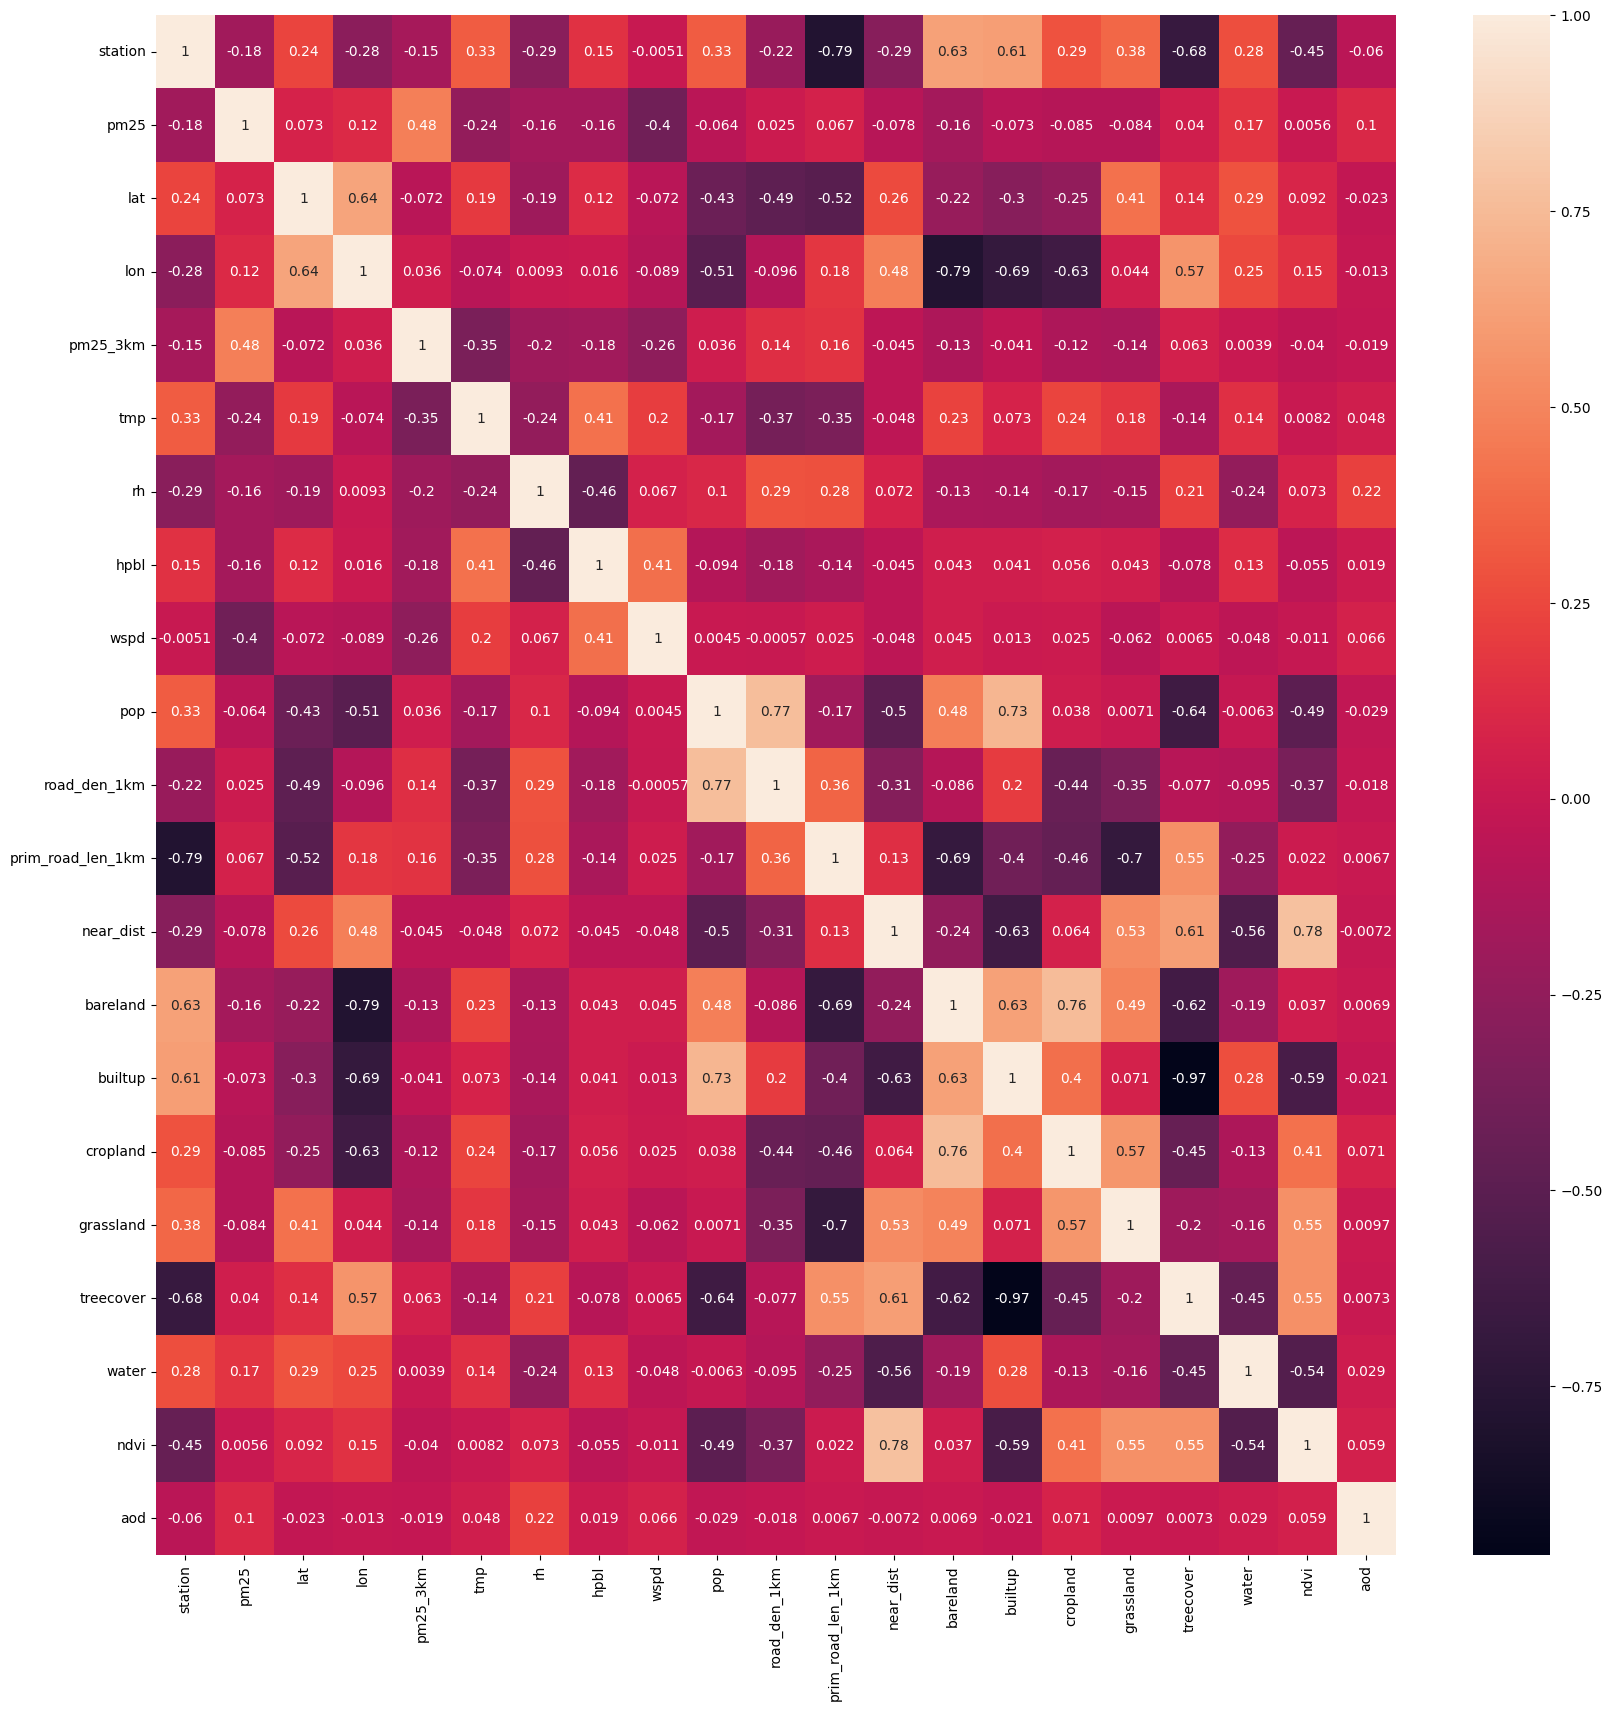

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_aod_raw.corr(), annot=True, ax=ax)
plt.show()

## Preprocessing

### Define label, static features and dynamic features

In [20]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['pm25_3km', 'tmp', 'aod', 'rh', 'hpbl', 'wspd']
aod_all_stations = [np.int64(201), np.int64(202), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216)]


### Fill "aod" column


Handling for station 201



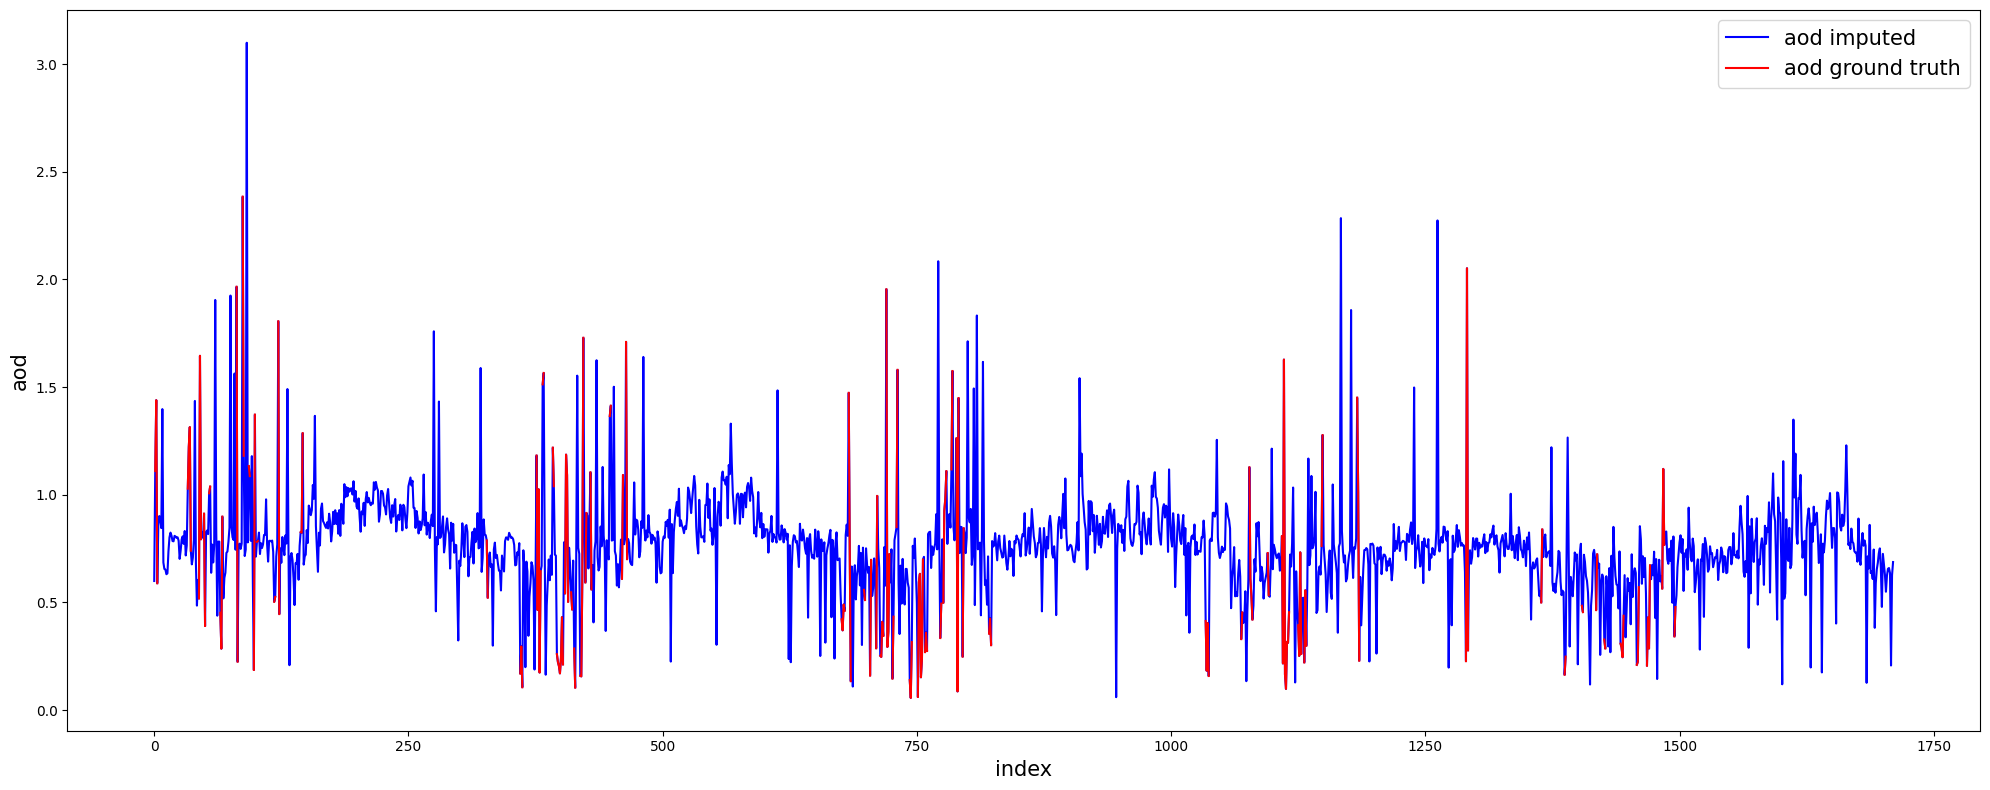


Handling for station 202



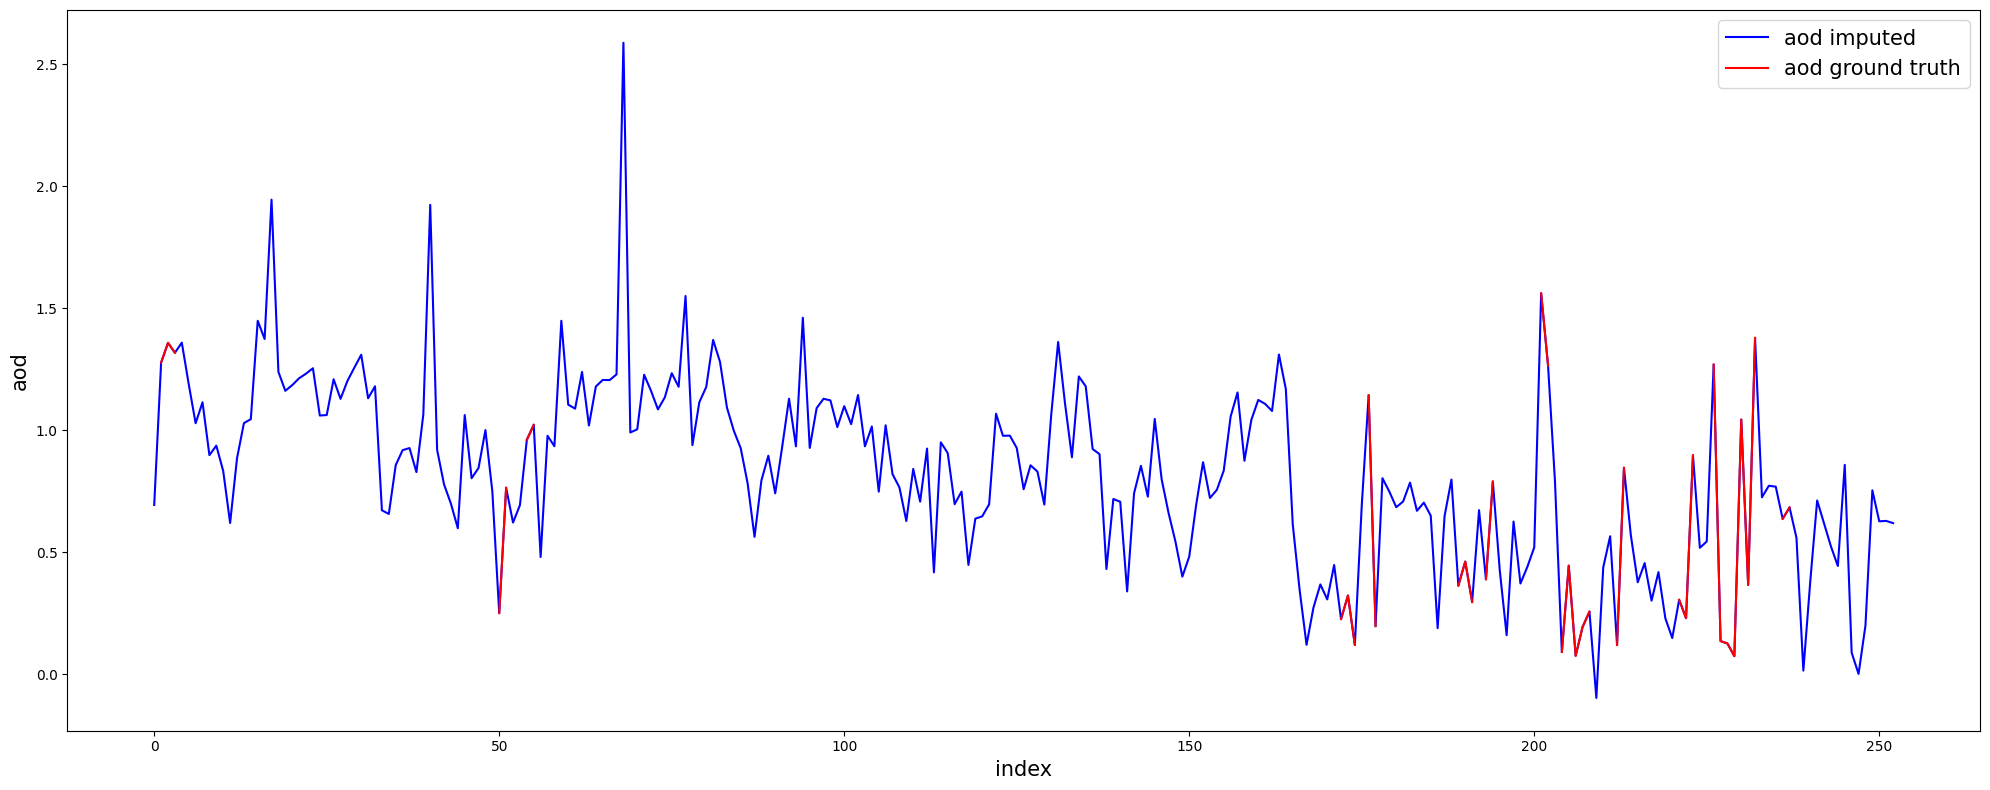


Handling for station 211



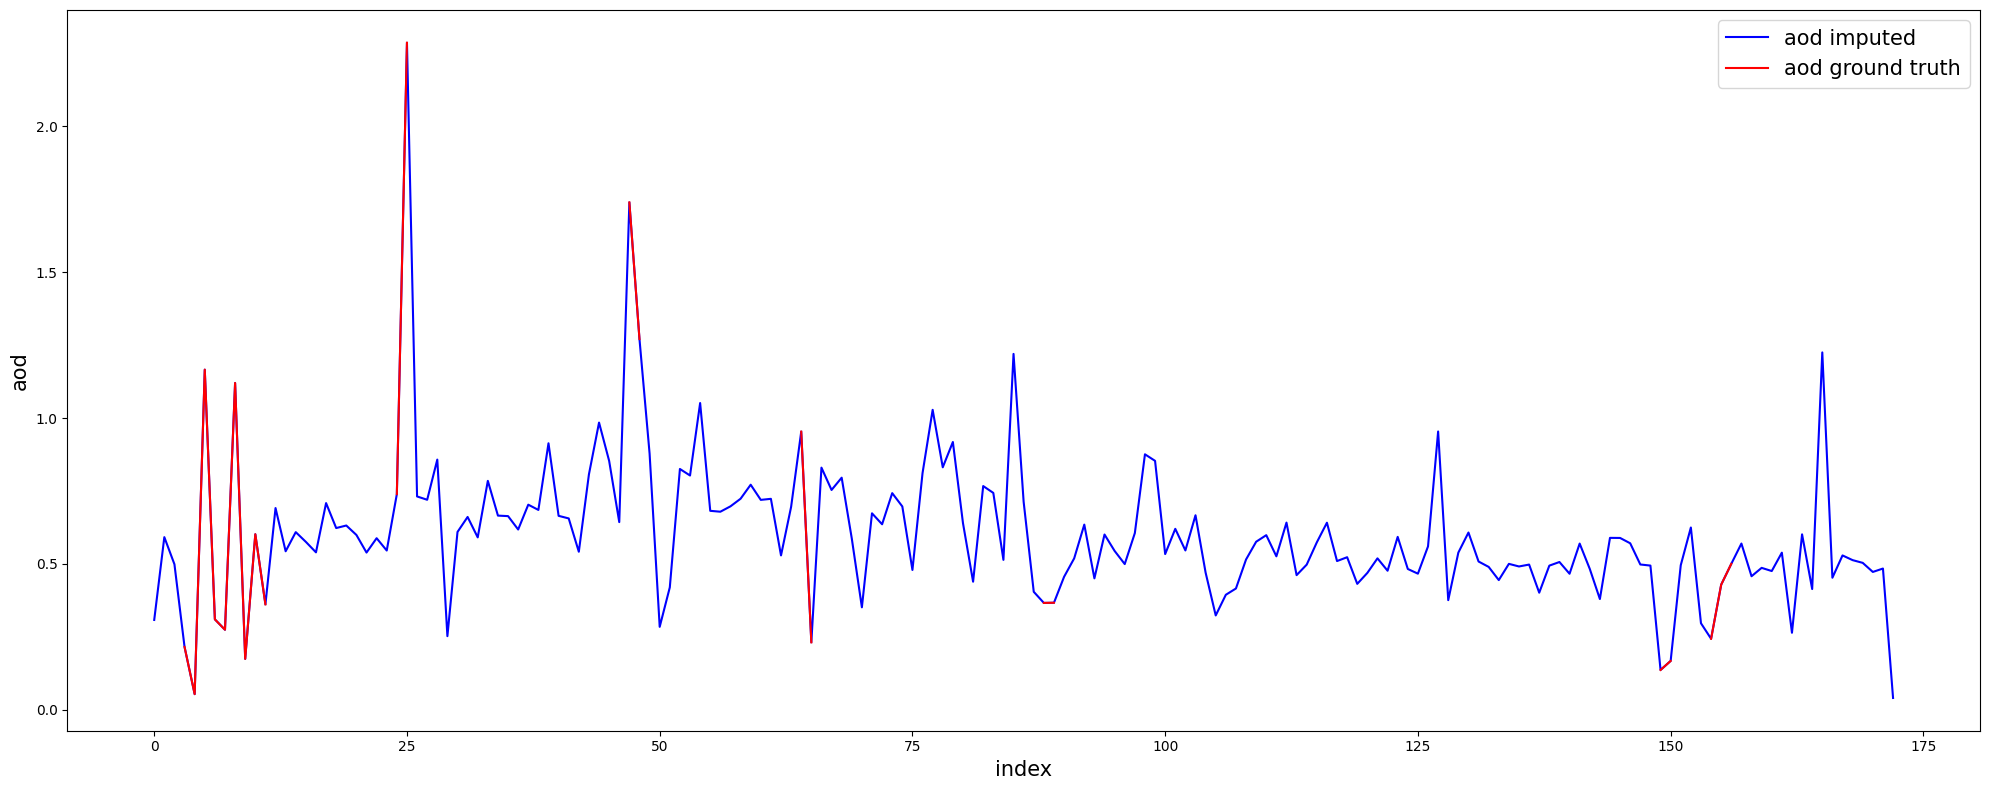


Handling for station 212



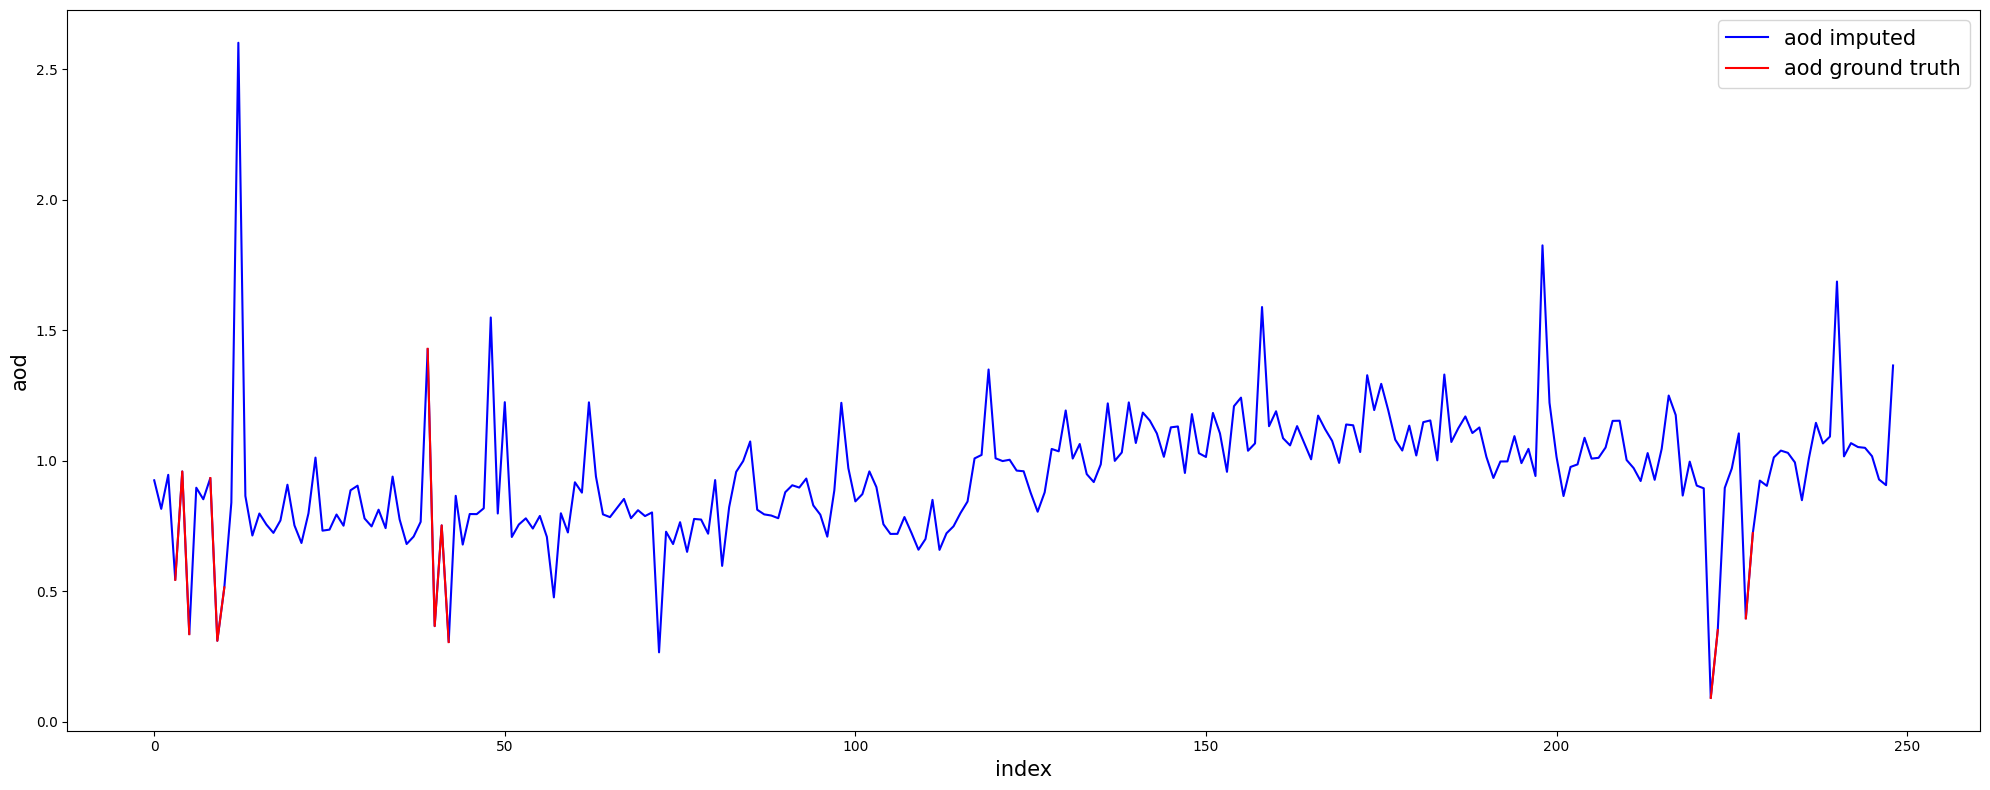


Handling for station 213



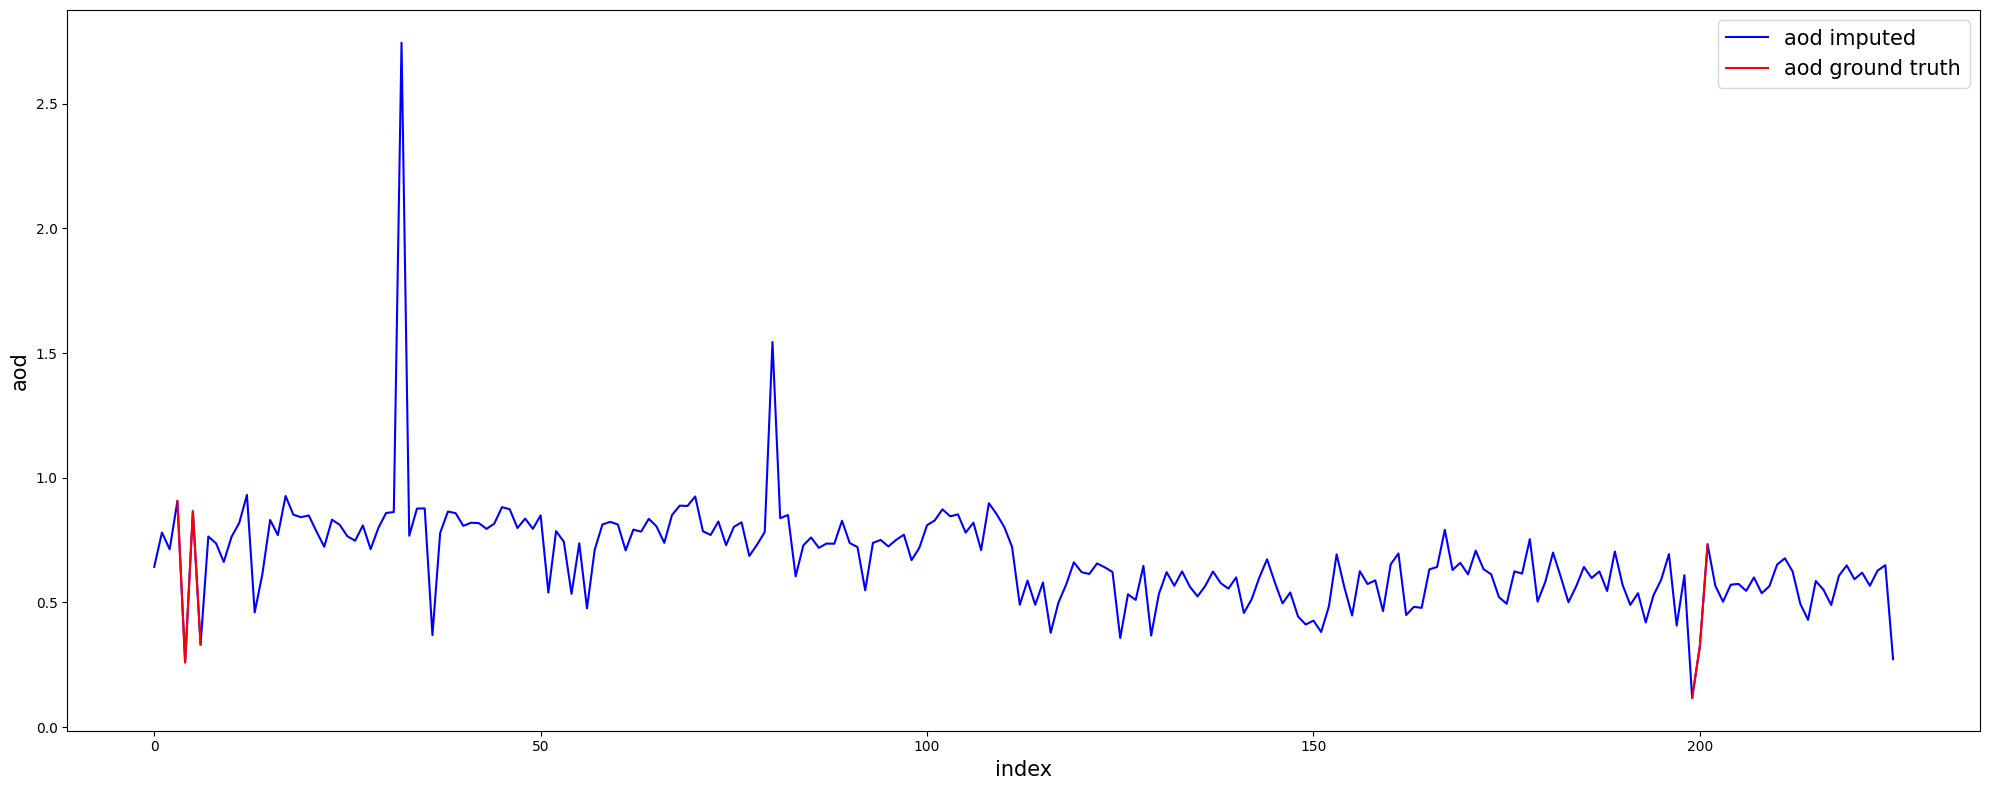


Handling for station 214



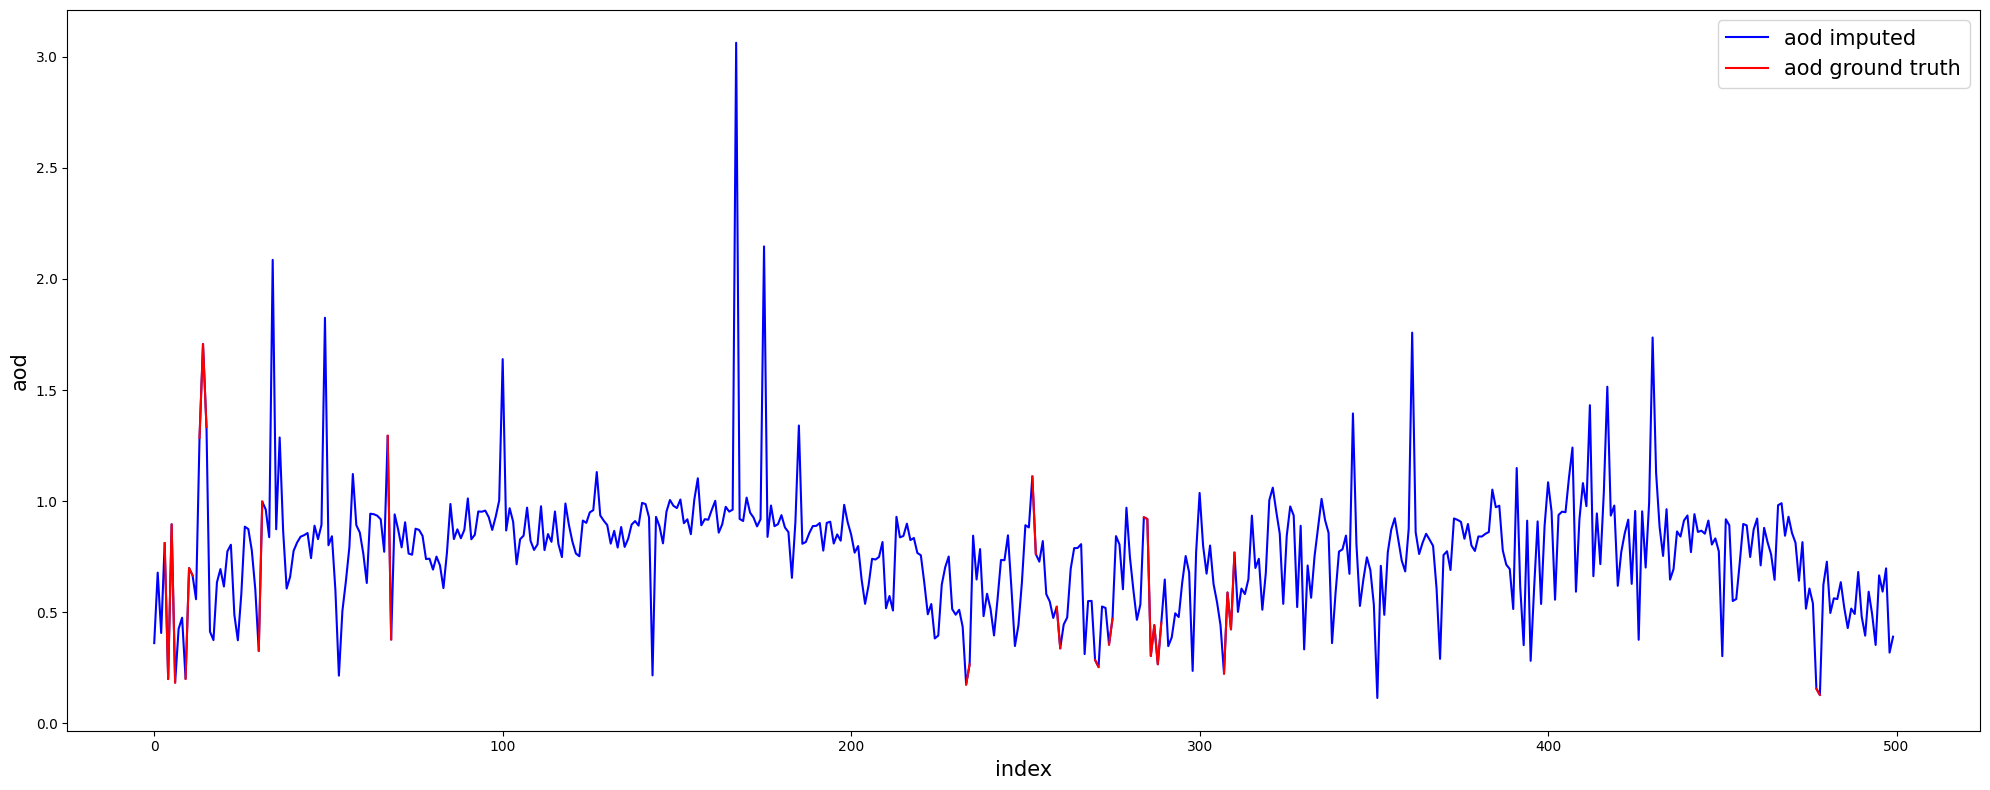


Handling for station 215



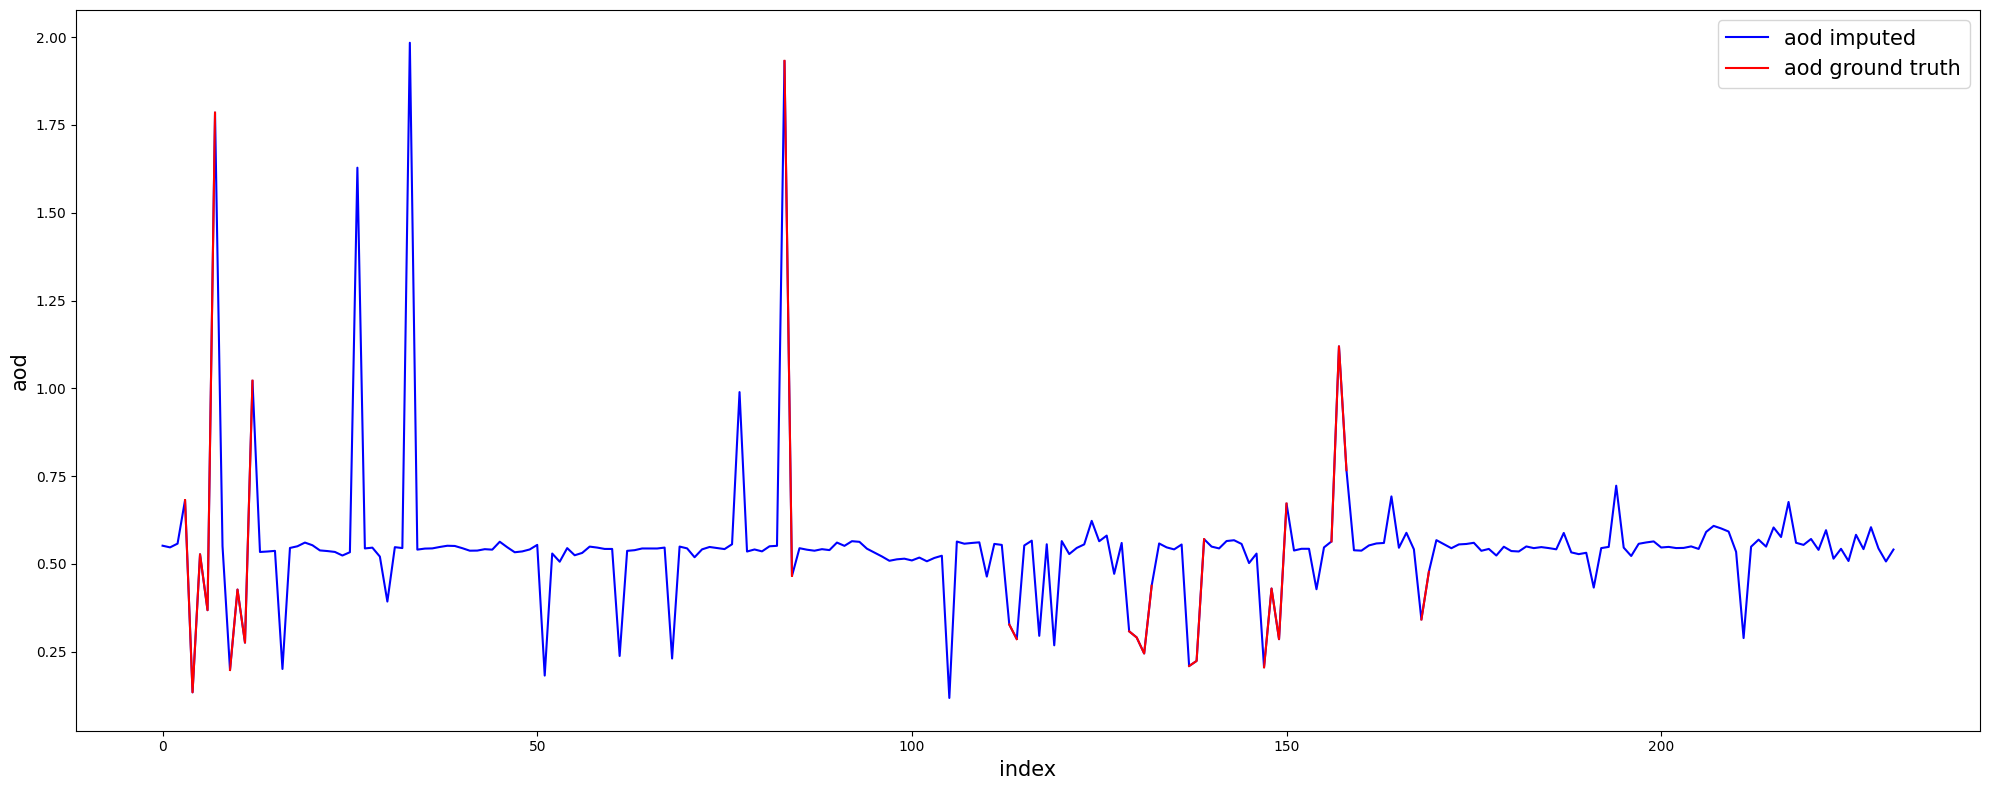


Handling for station 216



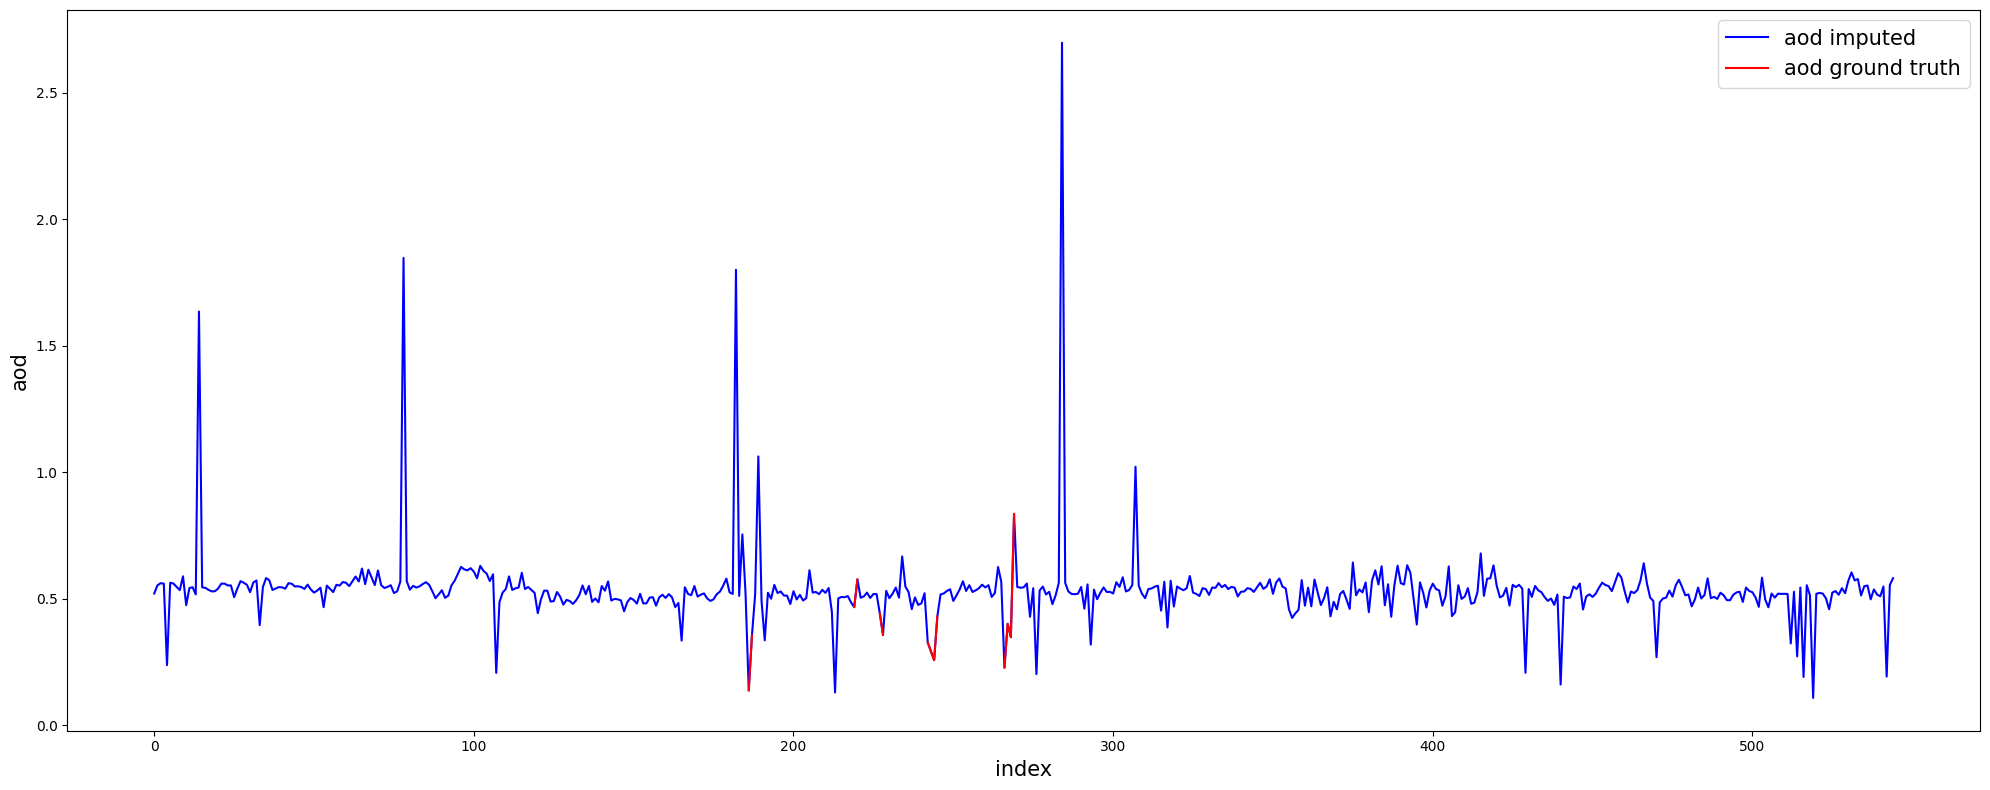

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[3889 rows x 21 columns]

In [21]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    #df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

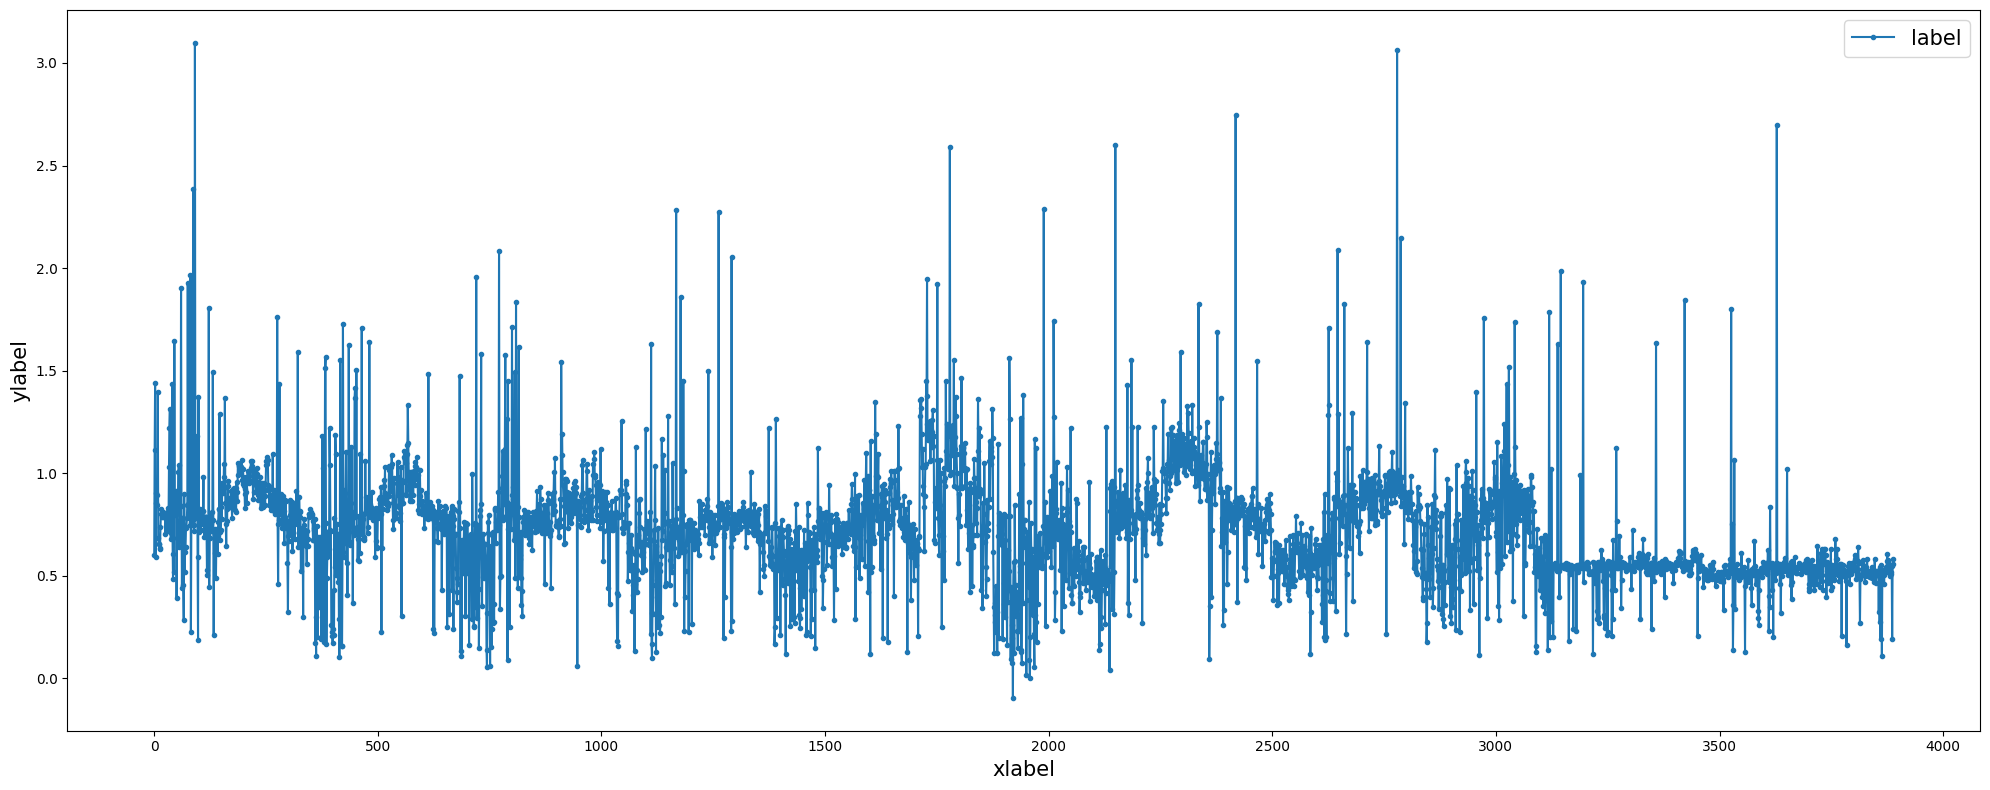

In [22]:
plot_1_data(df_aod["aod"])

In [23]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [24]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3889, freq=None)

In [25]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2018-01-01    201
2018-01-02    201
2018-01-03    201
2018-01-04    201
2018-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 3889, dtype: int64

In [26]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2018-01-01    34.919998
2018-01-02    51.830002
2018-01-03    38.240002
2018-01-04    40.259998
2018-01-05    21.690001
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 3889, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [27]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats

# Predict without "station" as a feature
# Remove "pm25_3km" also
aod_feats.remove("station")
aod_feats.remove("pm25_3km")
X_aod = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [28]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2018-01-01  10.783057  106.700606  20680.62695     27.462461   
2018-01-02  10.783057  106.700606  20680.62695     27.462461   
2018-01-03  10.783057  106.700606  20680.62695     27.462461   
2018-01-04  10.783057  106.700606  20680.62695     27.462461   
2018-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi        tmp  \
time                                                                   
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  25.204139   
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  24.726431   
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  26.095087   
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  26.514926   
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  25.483535   
...                 ...           ...    ...          ...        ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  24.136936   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  25.844296   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  25.841156   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  24.979719   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  25.364861   

                 aod         rh        hpbl      wspd  
time                                                   
2018-01-01  0.599173  70.056728  455.131335  2.352895  
2018-01-02  1.110117  73.425826  339.083720  1.903761  
2018-01-03  1.439045  77.793432  367.190738  1.293329  
2018-01-04  0.588595  82.982475  462.504210  1.588872  
2018-01-05  0.852506  93.046504  324.735356  2.505876  
...              ...        ...         ...       ...  
2022-12-27  0.508564  73.973083  457.798645  2.002987  
2022-12-28  0.547594  65.530487  644.974548  2.298220  
2022-12-29  0.191691  67.093735  825.517395  2.823764  
2022-12-30  0.554055  64.868401  680.533081  3.893373  
2022-12-31  0.580505  62.377899  799.122803  4.161542  

[3889 rows x 18 columns]

In [29]:
y_aod

pm25
time                 
2018-01-01  31.391304
2018-01-02  37.458333
2018-01-03  68.083333
2018-01-04  51.260870
2018-01-05  18.909091
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[3889 rows x 1 columns]

### Data normalization

In [30]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon       pop  road_den_1km  prim_road_len_1km  \
0     0.326794  0.466551  0.116512      0.471552           0.949821   
1     0.326794  0.466551  0.116512      0.471552           0.949821   
2     0.326794  0.466551  0.116512      0.471552           0.949821   
3     0.326794  0.466551  0.116512      0.471552           0.949821   
4     0.326794  0.466551  0.116512      0.471552           0.949821   
...        ...       ...       ...           ...                ...   
3884  0.306899  0.237227  0.857395      0.785926           0.323578   
3885  0.306899  0.237227  0.857395      0.785926           0.323578   
3886  0.306899  0.237227  0.857395      0.785926           0.323578   
3887  0.306899  0.237227  0.857395      0.785926           0.323578   
3888  0.306899  0.237227  0.857395      0.785926           0.323578   

      near_dist  bareland   builtup  cropland  grassland  treecover  water  \
0      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
1      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
2      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
3      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
4      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
...         ...       ...       ...       ...        ...        ...    ...   
3884   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3885   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3886   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3887   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3888   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   

          ndvi       tmp       aod        rh      hpbl      wspd  
0     0.526821  0.342735  0.217912  0.468797  0.300502  0.170694  
1     0.526821  0.303640  0.377783  0.543165  0.211553  0.110646  
2     0.526821  0.415649  0.480703  0.639575  0.233097  0.029033  
3     0.526821  0.450008  0.214603  0.754117  0.306153  0.068546  
4     0.526821  0.365600  0.297179  0.976269  0.200556  0.191147  
...        ...       ...       ...       ...       ...       ...  
3884  0.085003  0.255396  0.189562  0.555246  0.302546  0.123912  
3885  0.085003  0.395124  0.201774  0.368885  0.446013  0.163384  
3886  0.085003  0.394867  0.090414  0.403392  0.584396  0.233647  
3887  0.085003  0.324368  0.203795  0.354270  0.473268  0.376650  
3888  0.085003  0.355888  0.212071  0.299295  0.564165  0.412504  

[3889 rows x 18 columns]

In [31]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.325673
1     0.398696
2     0.767302
3     0.564825
4     0.175435
...        ...
3884  0.425193
3885  0.485609
3886  0.317649
3887  0.346136
3888  0.295134

[3889 rows x 1 columns]

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [32]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': []}

### Range of dimension

In [33]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
RANGE_OF_DIMENSION = range(11, 16)
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

13 14 15 16 17 

### Prediction without reduction

I0000 00:00:1757299712.174305 3257323 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 743 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


Model: "aod_LSTMPrediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     21,504 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 64)     │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 1)      │         65 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1757299715.073284 3263470 service.cc:152] XLA service 0x7bbcc80cf7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757299715.073314 3263470 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1757299715.551180 3263470 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757299721.280241 3263470 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


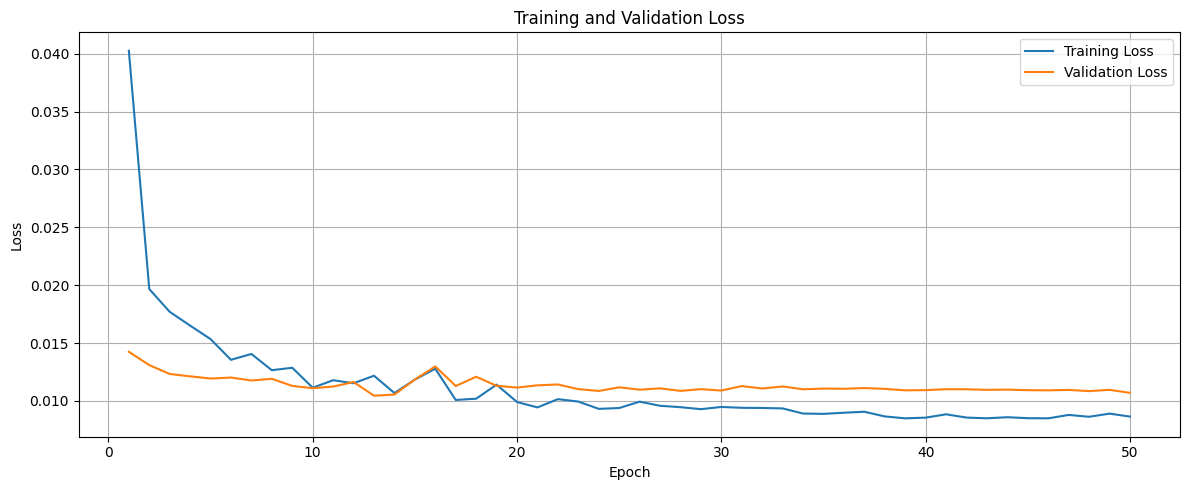

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


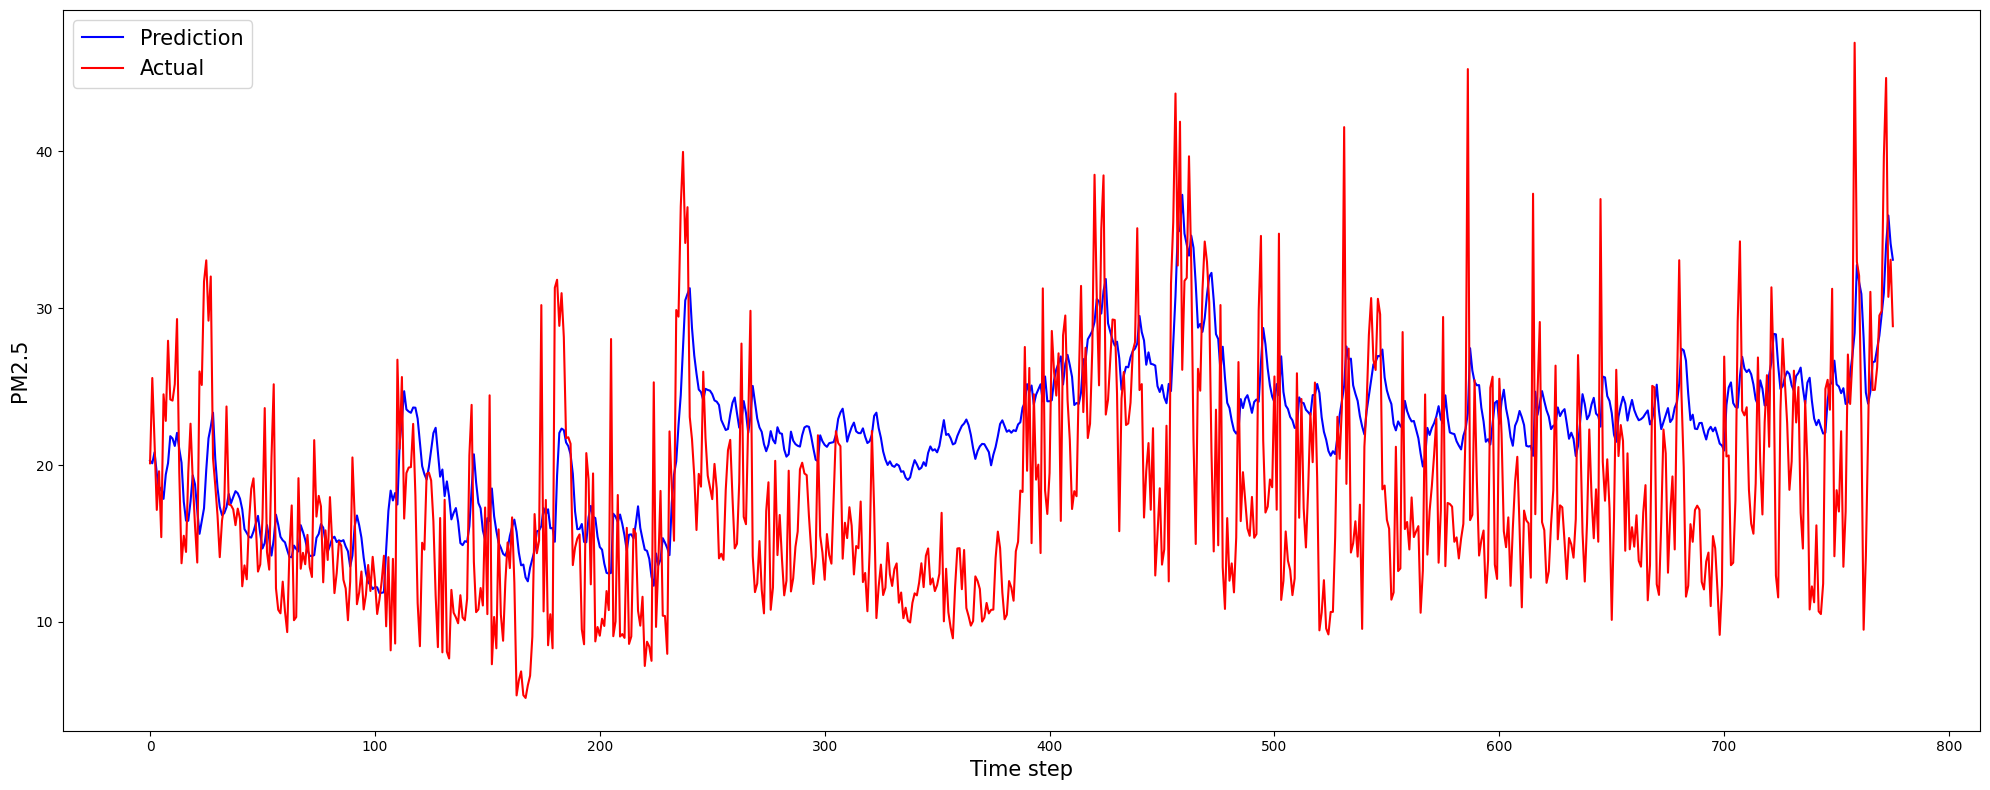

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  6.084257  51.476671   

       rmse        r2      mape  
0  7.174724 -1.606329  0.281083

In [34]:
# Prediction
lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, metrics = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
for m in LSTMPrediction.get_supported_metrics():
    evaluation_board[m] += [metrics[m][1]]
pd.DataFrame(evaluation_board)

### Prediction + LSTM-Seq2Seq

#### Doing the loop

Model: "aod_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 100)    │     47,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_2[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 13)        │        663 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 7, 13)     │          0 │ dense_1[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 7, 50)     │     12,800 │ repeat_vector_1[… │
│                     │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 7, 18)     │      1,818 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,445 (1.76 MB)

 Trainable params: 153,481 (599.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,964 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,463 (306.50 KB)

 Trainable params: 78,463 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 64),      │     20,224 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 1, 64)     │          0 │ lstm_6[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_2[… │
│                     │                   │            │ lstm_6[0][1],     │
│                     │                   │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 1)      │         65 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None


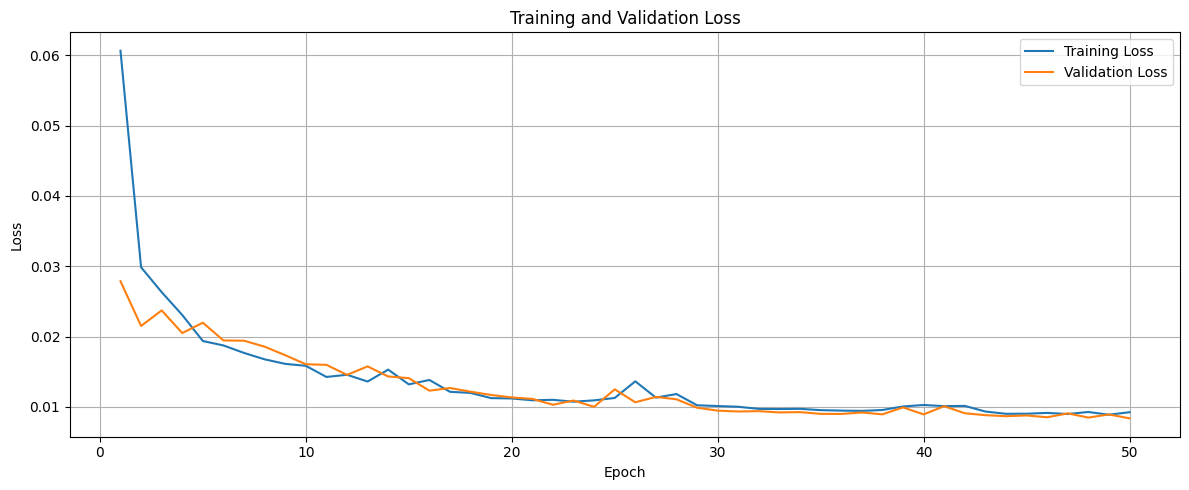

Model: "aod_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 100)    │     47,600 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_8[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 14)        │        714 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 7, 14)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_3[… │
│                     │                   │            │ lstm_9[0][1],     │
│                     │                   │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 18)     │      1,818 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_6[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 1, 64)     │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_4[… │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 1, 1)      │         65 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None


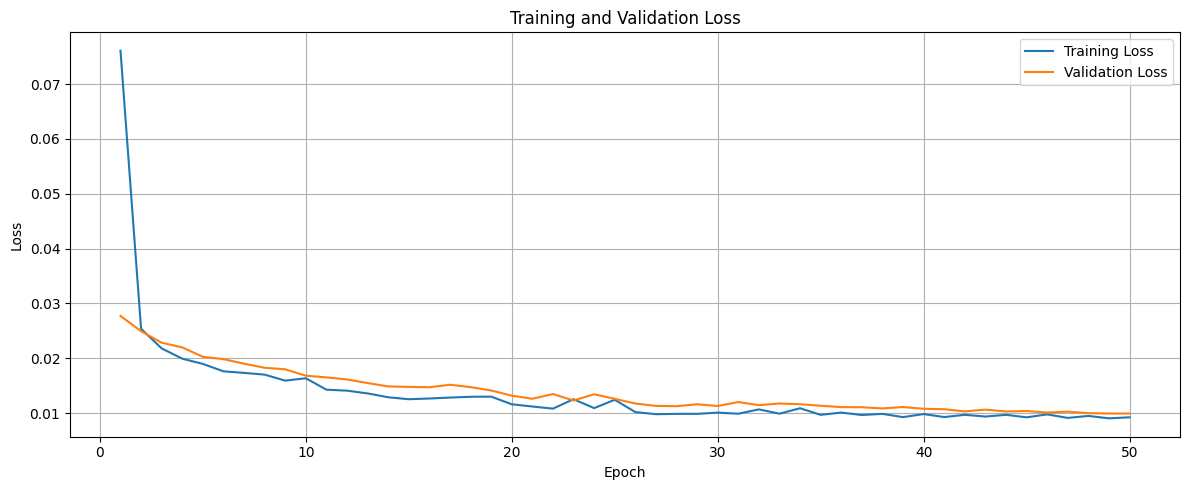

Model: "aod_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_14[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 15)        │        765 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 7, 15)     │          0 │ dense_7[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_5[… │
│                     │                   │            │ lstm_15[0][1],    │
│                     │                   │            │ lstm_15[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 7, 18)     │      1,818 │ lstm_17[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_9[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 1, 64)     │          0 │ lstm_18[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_6[… │
│                     │                   │            │ lstm_18[0][1],    │
│                     │                   │            │ lstm_18[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 64)     │          0 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 1, 1)      │         65 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None


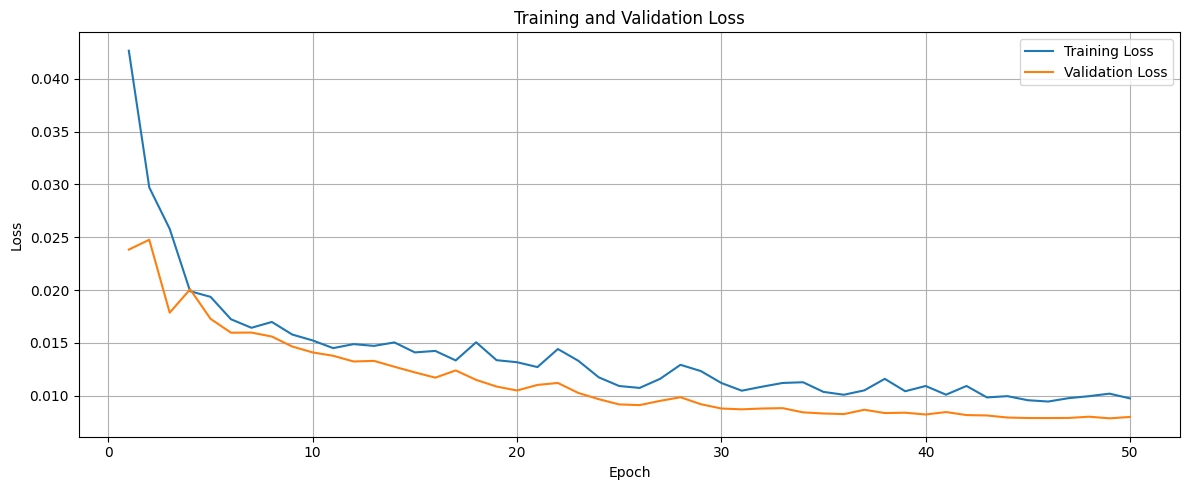

Model: "aod_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_20[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        816 │ lstm_21[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 7, 16)     │          0 │ dense_10[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_7[… │
│                     │                   │            │ lstm_21[0][1],    │
│                     │                   │            │ lstm_21[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_22[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 7, 18)     │      1,818 │ lstm_23[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_12[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 1, 64)     │          0 │ lstm_24[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_8[… │
│                     │                   │            │ lstm_24[0][1],    │
│                     │                   │            │ lstm_24[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 64)     │          0 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1, 1)      │         65 │ dropout_4[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None


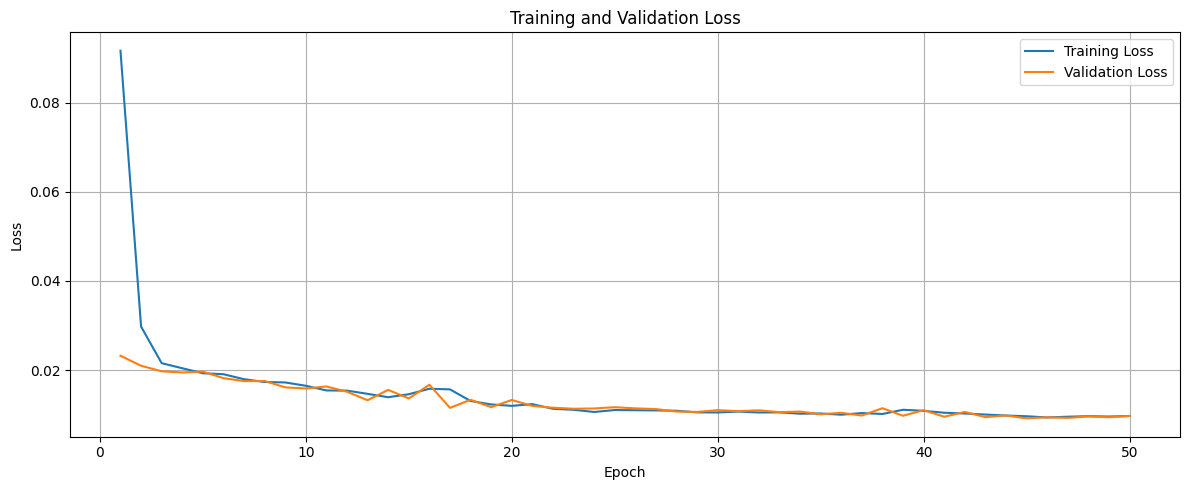

Model: "aod_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_26[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 17)        │        867 │ lstm_27[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 7, 17)     │          0 │ dense_13[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_9[… │
│                     │                   │            │ lstm_27[0][1],    │
│                     │                   │            │ lstm_27[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_28[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 18)     │      1,818 │ lstm_29[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_15[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 1, 64)     │          0 │ lstm_30[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_30[0][1],    │
│                     │                   │            │ lstm_30[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 64)     │          0 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 1, 1)      │         65 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None


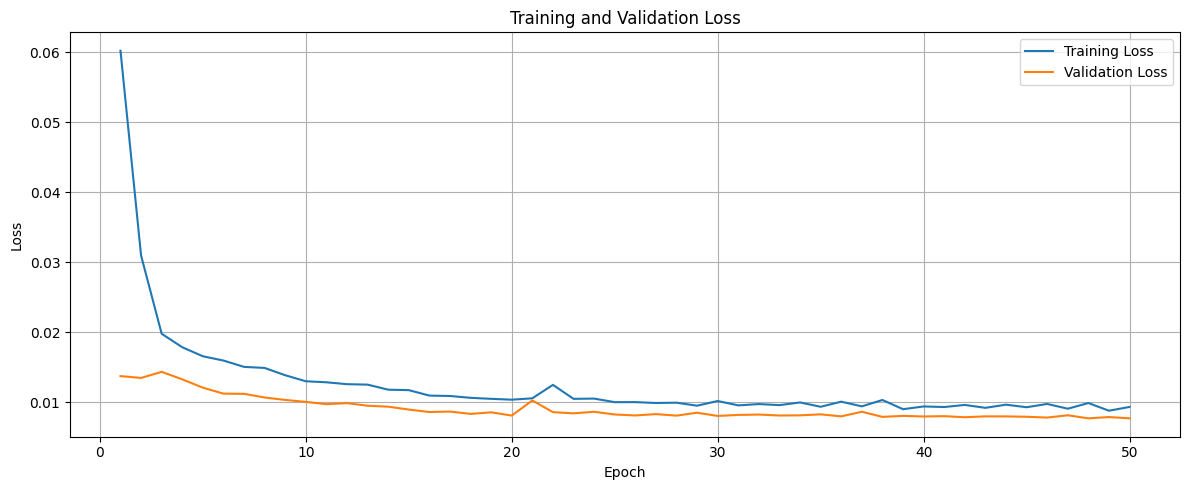

Choosing the best result

dict_keys([13, 14, 15, 16, 17])
N = 13
mae = 4.881976082965143
mse = 35.29118831792641
rmse = 5.94063871296062
r2 = -2.582003683344564
mape = 0.2539352318759475
N = 14
mae = 4.410261520747309
mse = 35.24592988784083
rmse = 5.93682826834673
r2 = -3.8077539241198153
mape = 0.2570650497416204
N = 15
mae = 4.294260898174689
mse = 32.141533704455206
rmse = 5.669350377640741
r2 = -1.8465338994906815
mape = 0.24345589788290575
N = 16
mae = 4.34545089307971
mse = 34.04894814511294
rmse = 5.835147654096933
r2 = -2.6237716930524146
mape = 0.25085506578004224
N = 17
mae = 4.336392188761963
mse = 31.673241479629308
rmse = 5.62789849585343
r2 = -1.4277954641821786
mape = 0.24256694402062073


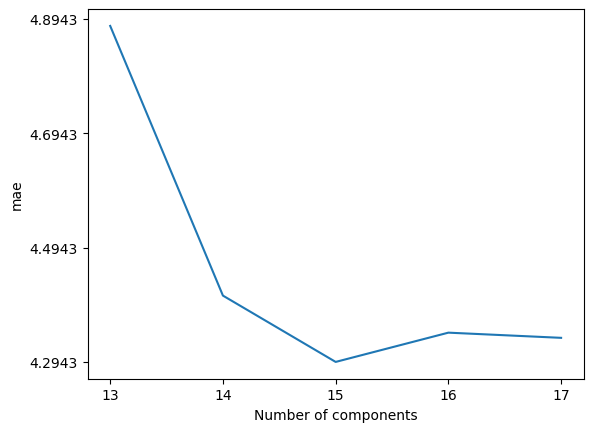

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


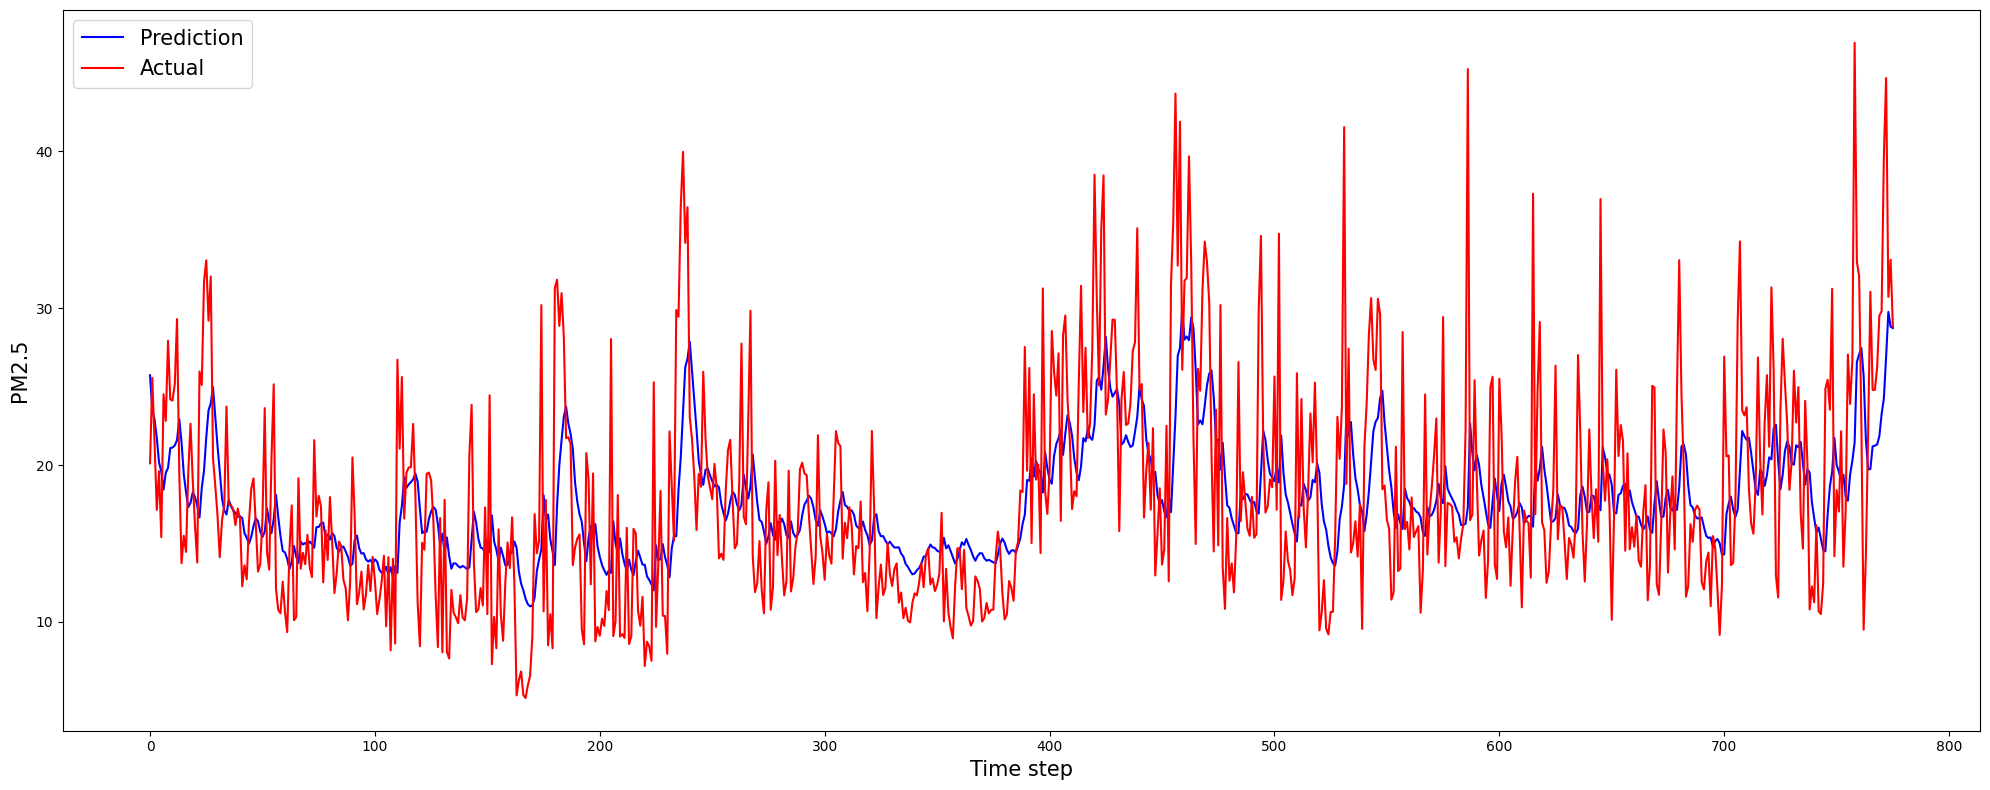

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  6.084257  51.476671   
1         LSTM-Seq2Seq                  15       LSTM  4.294261  32.141534   

       rmse        r2      mape  
0  7.174724 -1.606329  0.281083  
1  5.669350 -1.846534  0.243456

In [35]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [36]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.087364      -0.680366      -1.782153       1.400185   
2018-01-02       0.087364      -0.680366      -1.782153       1.400185   
2018-01-03       0.086953      -0.680959      -1.782070       1.401200   
2018-01-04       0.084347      -0.686695      -1.794145       1.411816   
2018-01-05       0.082393      -0.697460      -1.812933       1.426100   
...                   ...            ...            ...            ...   
2022-12-27       0.326968      -0.375102      -0.526312       0.409590   
2022-12-28       0.326627      -0.374873      -0.520498       0.406035   
2022-12-29       0.326721      -0.369828      -0.511468       0.400520   
2022-12-30       0.328218      -0.369652      -0.512295       0.402375   
2022-12-31       0.328855      -0.372069      -0.519146       0.407607   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.639054      -0.341230       0.943592       1.079895   
2018-01-02       0.639054      -0.341230       0.943592       1.079895   
2018-01-03       0.636952      -0.341803       0.946137       1.079349   
2018-01-04       0.633922      -0.345819       0.952360       1.084917   
2018-01-05       0.631140      -0.349779       0.962045       1.097731   
...                   ...            ...            ...            ...   
2022-12-27       0.256059       0.078004       0.511803       0.628264   
2022-12-28       0.254047       0.080713       0.514818       0.629579   
2022-12-29       0.252244       0.082500       0.511636       0.624837   
2022-12-30       0.253437       0.080774       0.507916       0.617930   
2022-12-31       0.255750       0.075546       0.503175       0.612142   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01      -1.719676        1.524520       -0.643296        2.158473   
2018-01-02      -1.719676        1.524520       -0.643296        2.158473   
2018-01-03      -1.718207        1.523777       -0.640496        2.156990   
2018-01-04      -1.724435        1.531814       -0.639146        2.167996   
2018-01-05      -1.737765        1.548328       -0.638624        2.190443   
...                   ...             ...             ...             ...   
2022-12-27      -0.644145        0.519428       -0.376278        0.802665   
2022-12-28      -0.638957        0.515393       -0.371496        0.797731   
2022-12-29      -0.627043        0.507477       -0.368164        0.787209   
2022-12-30      -0.628045        0.509474       -0.372320        0.787822   
2022-12-31      -0.637252        0.514688       -0.379814        0.794212   

            aod_feature_13  aod_feature_14  aod_feature_15  station  
time                                                                 
2018-01-01        0.368596       -0.012925       -0.992675      201  
2018-01-02        0.368596       -0.012925       -0.992675      201  
2018-01-03        0.369017       -0.014031       -0.991321      201  
2018-01-04        0.371648       -0.013450       -0.997433      201  
2018-01-05        0.376393       -0.006448       -1.011402      201  
...                    ...             ...             ...      ...  
2022-12-27        0.265942        0.129121       -0.308174      216  
2022-12-28        0.265007        0.130068       -0.307324      216  
2022-12-29        0.261285        0.127506       -0.302801      216  
2022-12-30        0.260606        0.126236       -0.301297      216  
2022-12-31        0.262241        0.123746       -0.299693      216  

[3889 rows x 16 columns]

In [37]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_lstms2s_reduced_augmented = augmentReducedData(df_lstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_lstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_lstms2s_reduced_augmented

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.087364      -0.680366      -1.782153       1.400185   
2018-01-02       0.087364      -0.680366      -1.782153       1.400185   
2018-01-03       0.086953      -0.680959      -1.782070       1.401200   
2018-01-04       0.084347      -0.686695      -1.794145       1.411816   
2018-01-05       0.082393      -0.697460      -1.812933       1.426100   
...                   ...            ...            ...            ...   
2022-12-27       0.326968      -0.375102      -0.526312       0.409590   
2022-12-28       0.326627      -0.374873      -0.520498       0.406035   
2022-12-29       0.326721      -0.369828      -0.511468       0.400520   
2022-12-30       0.328218      -0.369652      -0.512295       0.402375   
2022-12-31       0.328855      -0.372069      -0.519146       0.407607   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.639054      -0.341230       0.943592       1.079895   
2018-01-02       0.639054      -0.341230       0.943592       1.079895   
2018-01-03       0.636952      -0.341803       0.946137       1.079349   
2018-01-04       0.633922      -0.345819       0.952360       1.084917   
2018-01-05       0.631140      -0.349779       0.962045       1.097731   
...                   ...            ...            ...            ...   
2022-12-27       0.256059       0.078004       0.511803       0.628264   
2022-12-28       0.254047       0.080713       0.514818       0.629579   
2022-12-29       0.252244       0.082500       0.511636       0.624837   
2022-12-30       0.253437       0.080774       0.507916       0.617930   
2022-12-31       0.255750       0.075546       0.503175       0.612142   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01      -1.719676        1.524520       -0.643296        2.158473   
2018-01-02      -1.719676        1.524520       -0.643296        2.158473   
2018-01-03      -1.718207        1.523777       -0.640496        2.156990   
2018-01-04      -1.724435        1.531814       -0.639146        2.167996   
2018-01-05      -1.737765        1.548328       -0.638624        2.190443   
...                   ...             ...             ...             ...   
2022-12-27      -0.644145        0.519428       -0.376278        0.802665   
2022-12-28      -0.638957        0.515393       -0.371496        0.797731   
2022-12-29      -0.627043        0.507477       -0.368164        0.787209   
2022-12-30      -0.628045        0.509474       -0.372320        0.787822   
2022-12-31      -0.637252        0.514688       -0.379814        0.794212   

            aod_feature_13  aod_feature_14  aod_feature_15  station  \
time                                                                  
2018-01-01        0.368596       -0.012925       -0.992675      201   
2018-01-02        0.368596       -0.012925       -0.992675      201   
2018-01-03        0.369017       -0.014031       -0.991321      201   
2018-01-04        0.371648       -0.013450       -0.997433      201   
2018-01-05        0.376393       -0.006448       -1.011402      201   
...                    ...             ...             ...      ...   
2022-12-27        0.265942        0.129121       -0.308174      216   
2022-12-28        0.265007        0.130068       -0.307324      216   
2022-12-29        0.261285        0.127506       -0.302801      216   
2022-12-30        0.260606        0.126236       -0.301297      216   
2022-12-31        0.262241        0.123746       -0.299693      216   

             pm25_3km  hiep_predicted_pm25  
time                                        
2018-01-01  34.919998            23.102837  
2018-01-02  51.830002    

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.294260898174689
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 32.141533704455206


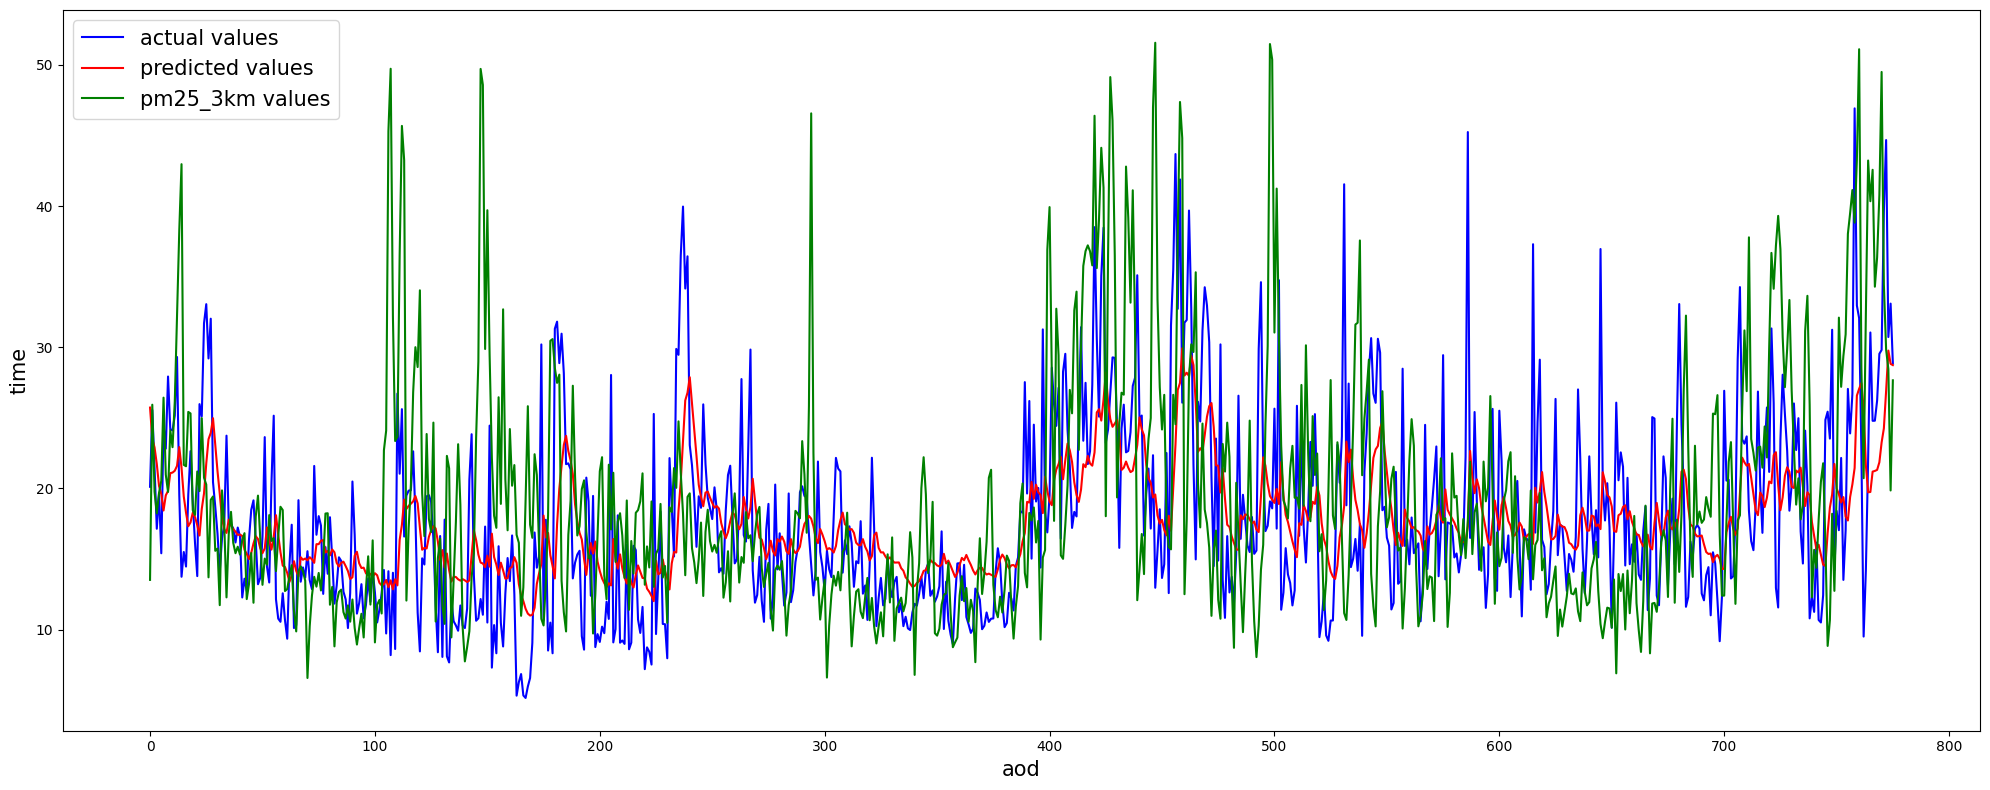

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 6.10609245300293


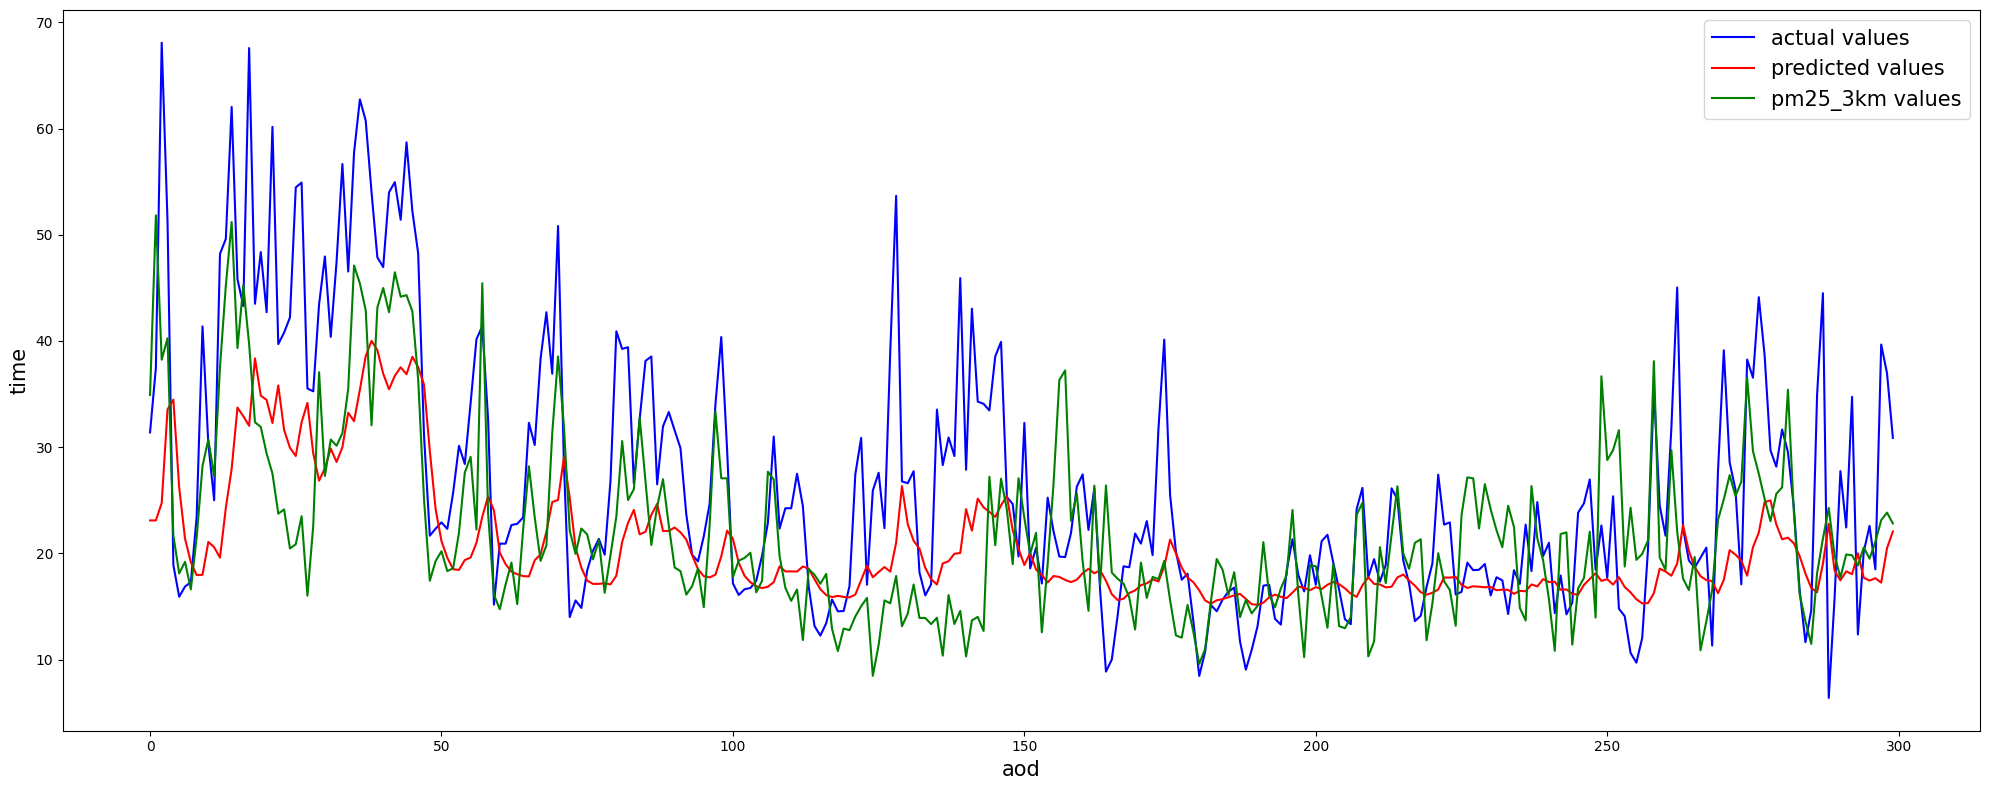

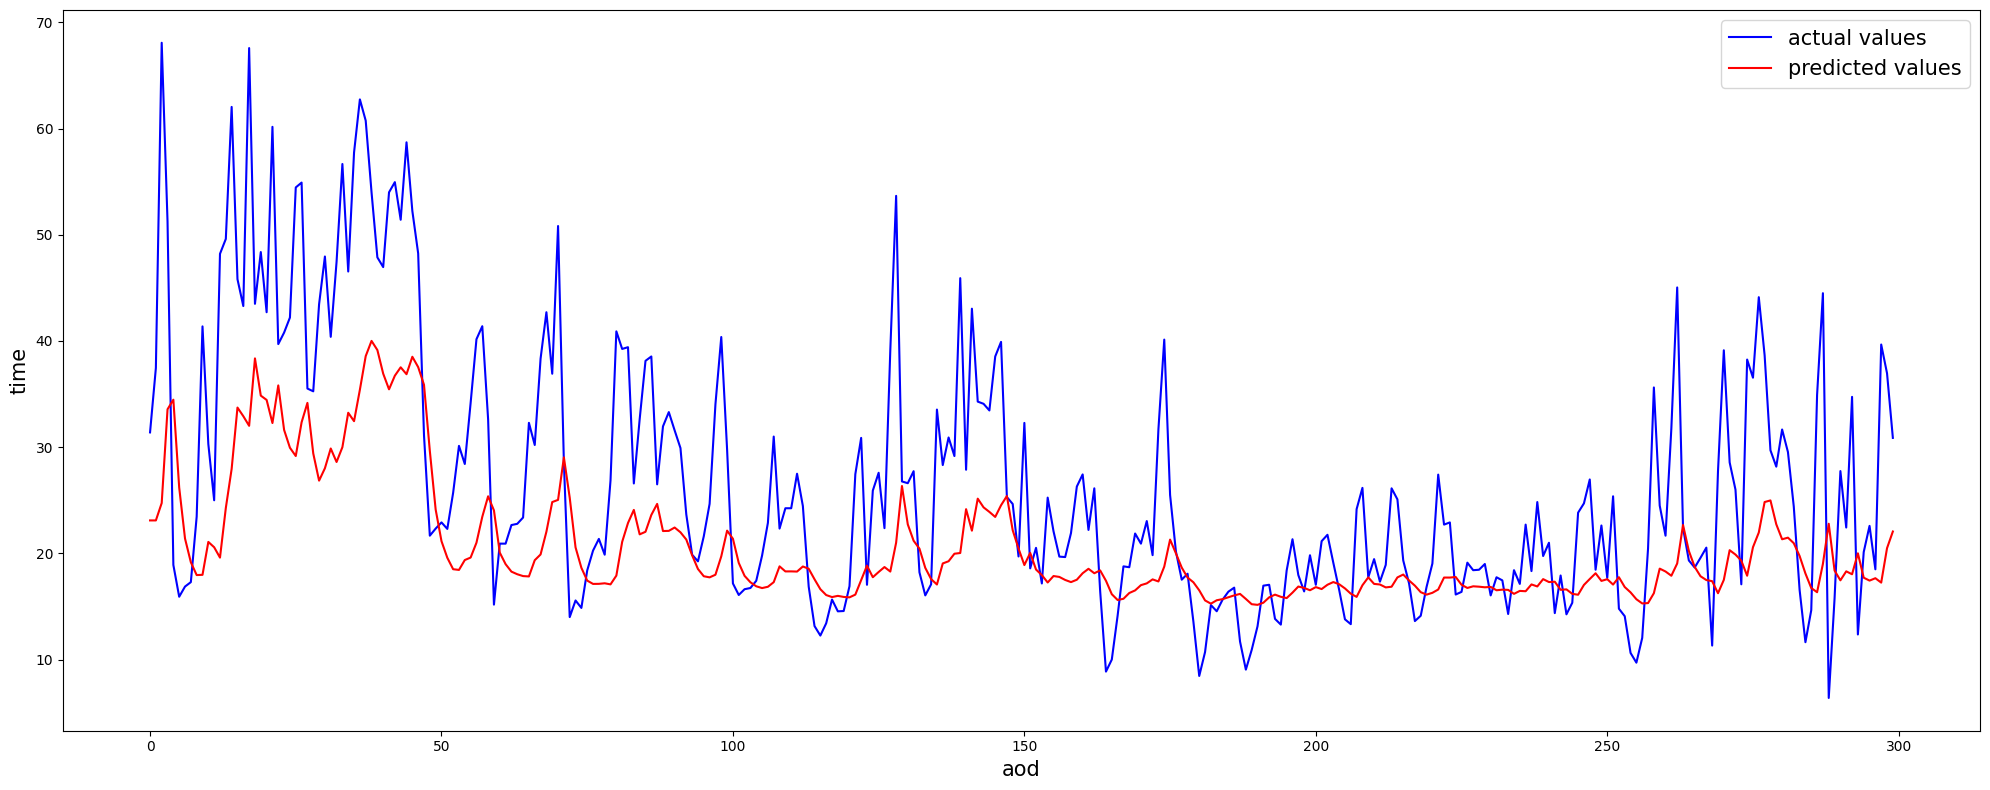

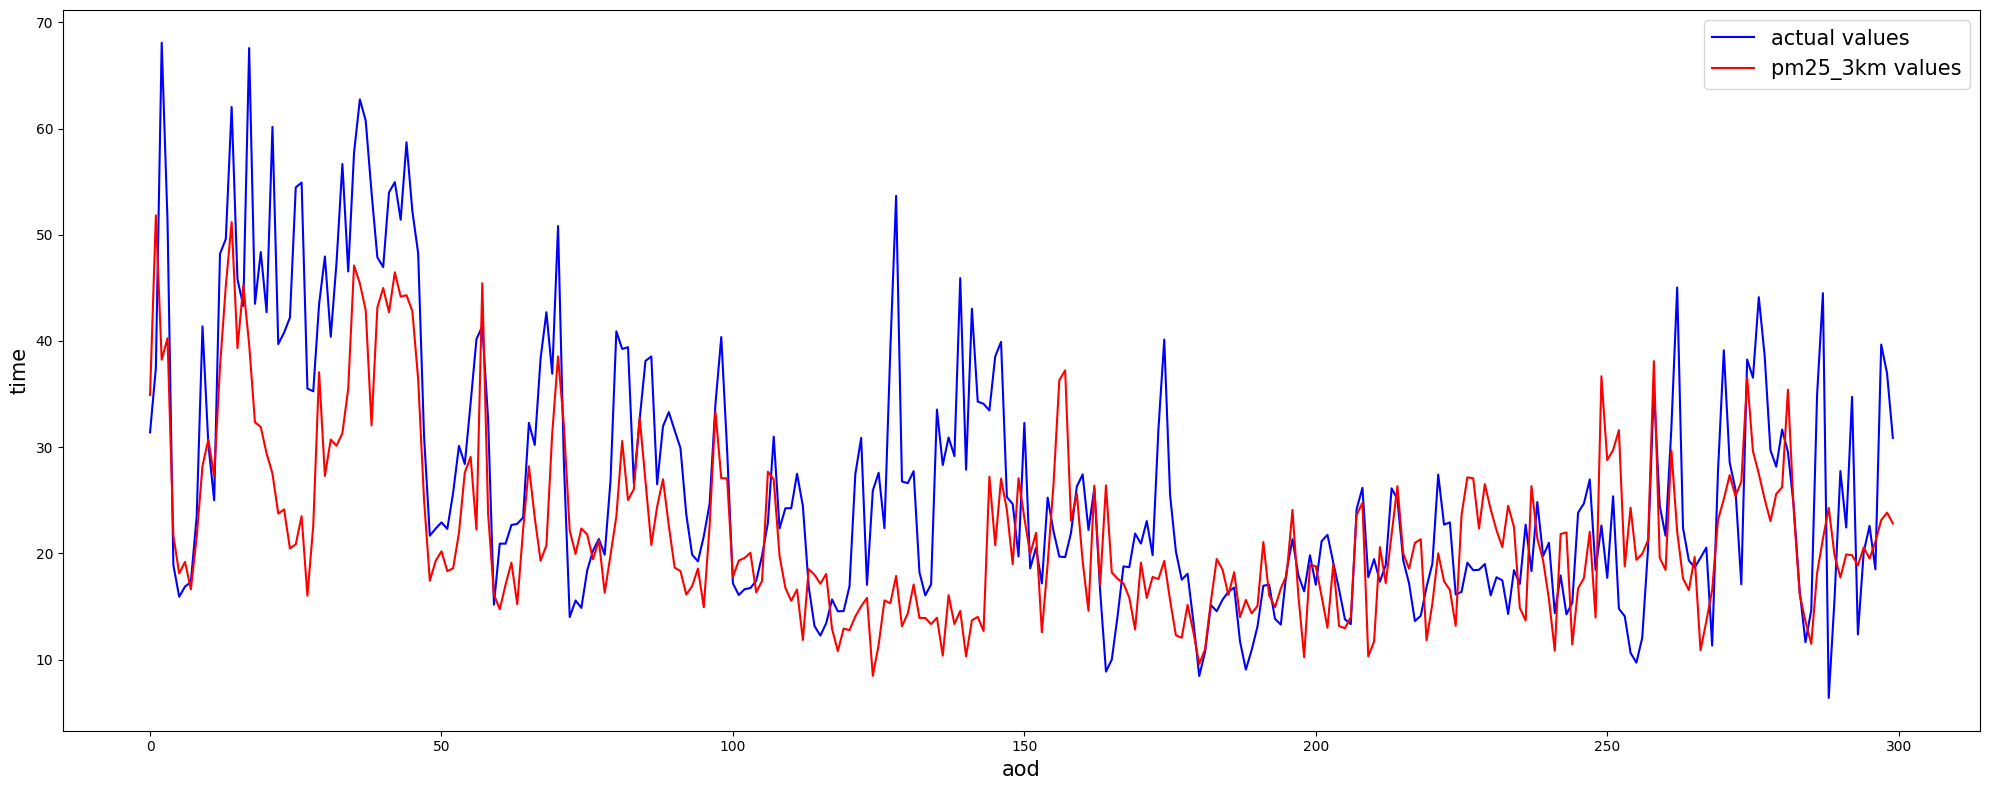

In [38]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_lstms2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

#### Compare MAE with CMAQ pm25

[201 211 212 213 214 215 216]
[201 211 212 213 214 215 216]
[201 211 212 213 214 215 216]


station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2022-01-01      201  21.695652  10.783456  106.700622  22.705284  27.787918   
2022-01-02      201  24.583333  10.783456  106.700622  24.095436  24.707085   
2022-01-03      201  31.083333  10.783456  106.700622  45.302227  26.576595   
2022-01-04      201  50.916667  10.783456  106.700622  49.729404  26.506687   
2022-01-05      201  33.041667  10.783456  106.700622  32.204433  26.590250   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2022-01-01  61.073841  659.863586  1.885687  20680.62695  ...   
2022-01-02  65.996597  432.379822  1.432167  20680.62695  ...   
2022-01-03  66.171082  443.947327  1.533191  20680.62695  ...   
2022-01-04  76.320465  432.340332  1.721378  20680.62695  ...   
2022-01-05  79.178970  459.642944  1.762114  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2022-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2022-01-01  1876.639945  232011.95950    0.0  2700.122924  0.118424  
2022-01-02  1876.639945  232011.95950    0.0  2700.122924  0.484536  
2022-01-03  1876.639945  232011.95950    0.0  2700.122924  0.555172  
2022-01-04  1876.639945  232011.95950    0.0  2700.122924  0.726901  
2022-01-05  1876.639945  232011.95950    0.0  2700.122924  0.743757  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[998 rows x 21 columns]

hiep_predicted_pm25  station
time                                    
2022-01-01            18.409359      201
2022-01-02            18.049850      201
2022-01-03            18.269476      201
2022-01-04            19.781326      201
2022-01-05            25.624302      201
...                         ...      ...
2022-12-27            25.913708      216
2022-12-28            29.020502      216
2022-12-29            32.165554      216
2022-12-30            30.652351      216
2022-12-31            30.538025      216

[998 rows x 2 columns]

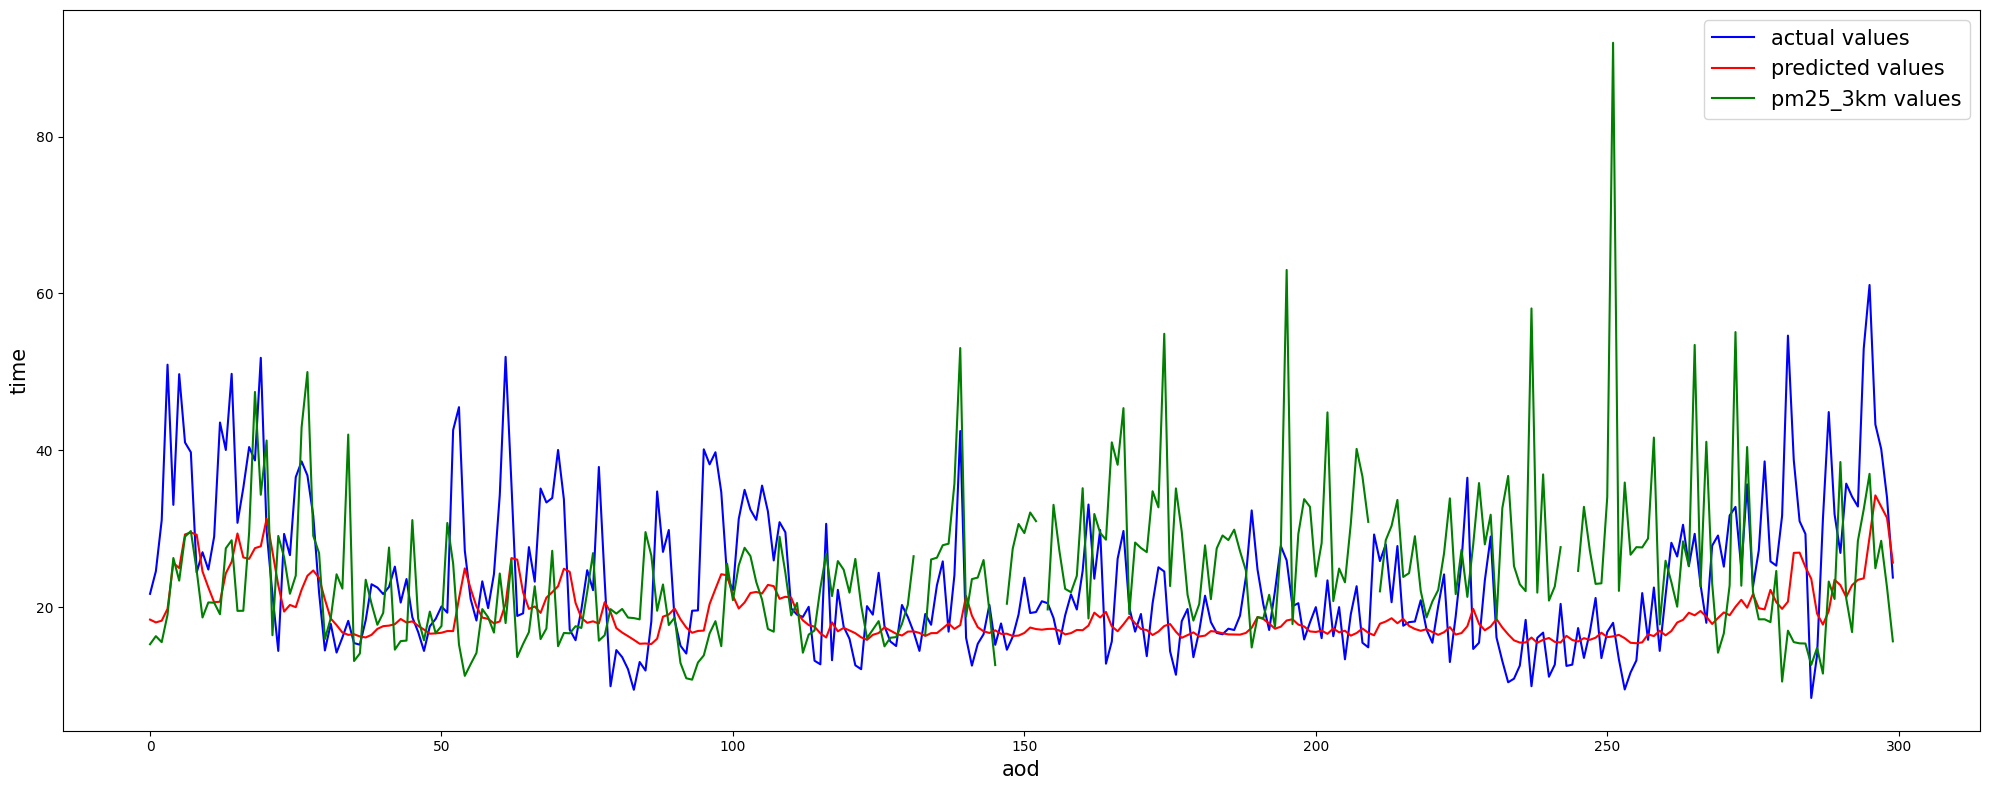

In [39]:
# Append pred all
df_pred_all = pd.concat([y_pred_all, aod_station_column], axis=1)
df_pred_all

# Remove station 202
df_pred_all_dropped_202 = df_pred_all[df_pred_all["station"] != 202]
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]

print(df_aod_dropped_202["station"].unique())
print(df_pred_all_dropped_202["station"].unique())
print(df_cmaq_daily["station"].unique())

time_mask = ((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))
df_aod_dropped_202 = df_aod_dropped_202.loc[time_mask]
display(df_aod_dropped_202)

time_mask = ((df_pred_all_dropped_202.index >= "2022-01-01") & (df_pred_all_dropped_202.index <= "2022-12-31"))
df_pred_all_dropped_202 = df_pred_all_dropped_202.loc[time_mask]
display(df_pred_all_dropped_202)

# Compare entire dataset
plot_3_data(data1=df_aod_dropped_202["pm25"].head(300),
           datalabel1="actual pm25 values",
           data2=df_pred_all_dropped_202["hiep_predicted_pm25"].head(300),
           datalabel2="predicted pm25 values",
           data3=df_cmaq_daily["pm25"].head(300),
           datalabel3="cmaq pm25 values",
           ylabel="time",
           xlabel="aod")

### Prediction + GRU-Seq2Seq

#### Doing the loop

Model: "aod_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,000 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 13)        │        663 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 13)     │          0 │ dense_17[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │      9,750 │ repeat_vector_12… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 7, 18)     │      1,818 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,895 (1.33 MB)

 Trainable params: 116,631 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,264 (911.19 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,463 (232.28 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_19[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_13    │ (None, 1, 64)     │          0 │ lstm_34[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_13… │
│                     │                   │            │ lstm_34[0][1],    │
│                     │                   │            │ lstm_34[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 64)     │          0 │ lstm_35[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 1, 1)      │         65 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None


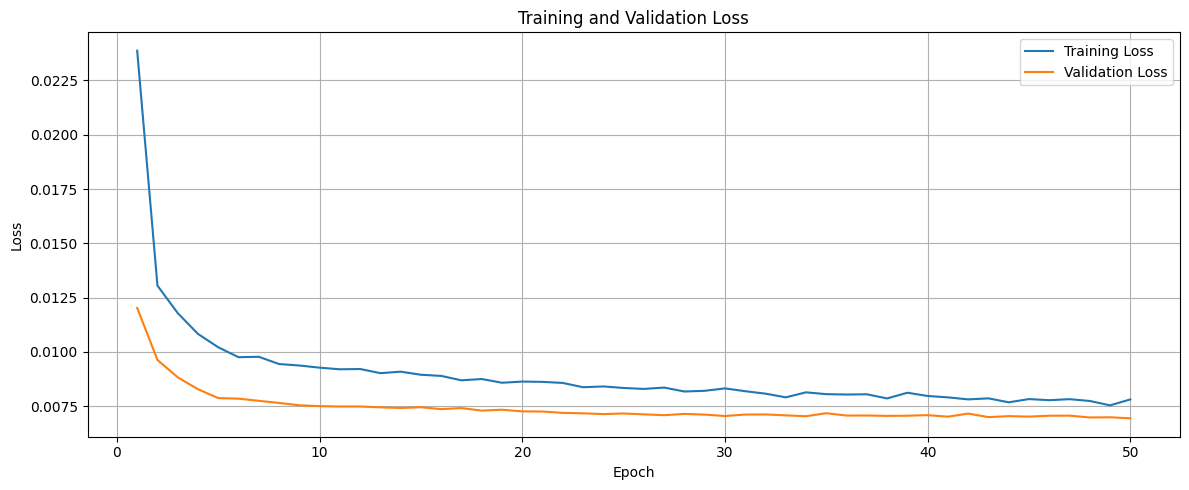

Model: "aod_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 14)        │        714 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 14)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │      9,900 │ repeat_vector_14… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 7, 18)     │      1,818 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,498 (1.34 MB)

 Trainable params: 116,832 (456.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,666 (912.76 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,514 (232.48 KB)

 Trainable params: 59,514 (232.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_22[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 1, 64)     │          0 │ lstm_36[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_15… │
│                     │                   │            │ lstm_36[0][1],    │
│                     │                   │            │ lstm_36[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1, 64)     │          0 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 1, 1)      │         65 │ dropout_8[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None


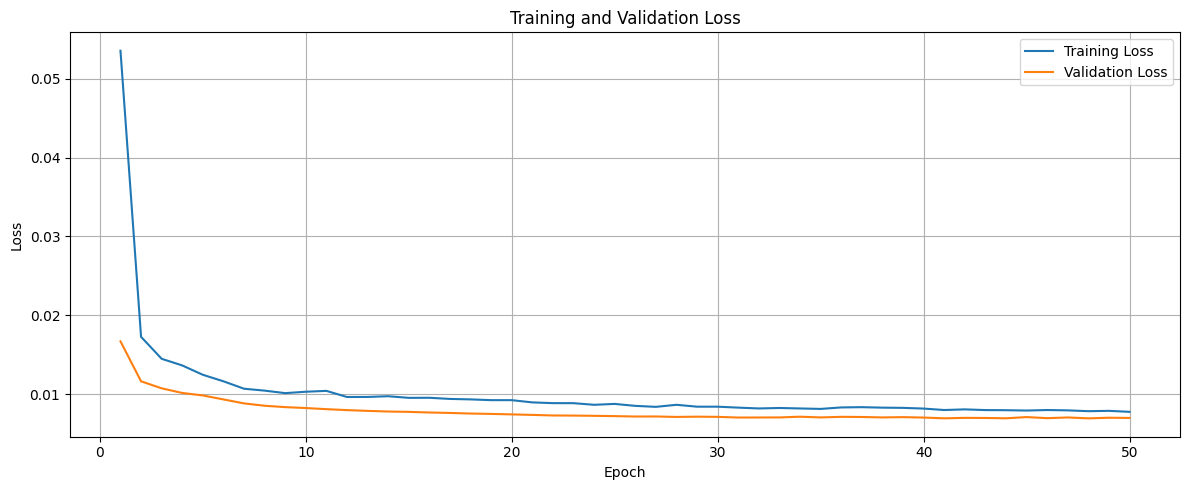

Model: "aod_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 15)        │        765 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 15)     │          0 │ dense_23[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_16… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 7, 18)     │      1,818 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_25[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_17    │ (None, 1, 64)     │          0 │ lstm_38[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_17… │
│                     │                   │            │ lstm_38[0][1],    │
│                     │                   │            │ lstm_38[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 64)     │          0 │ lstm_39[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 1, 1)      │         65 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None


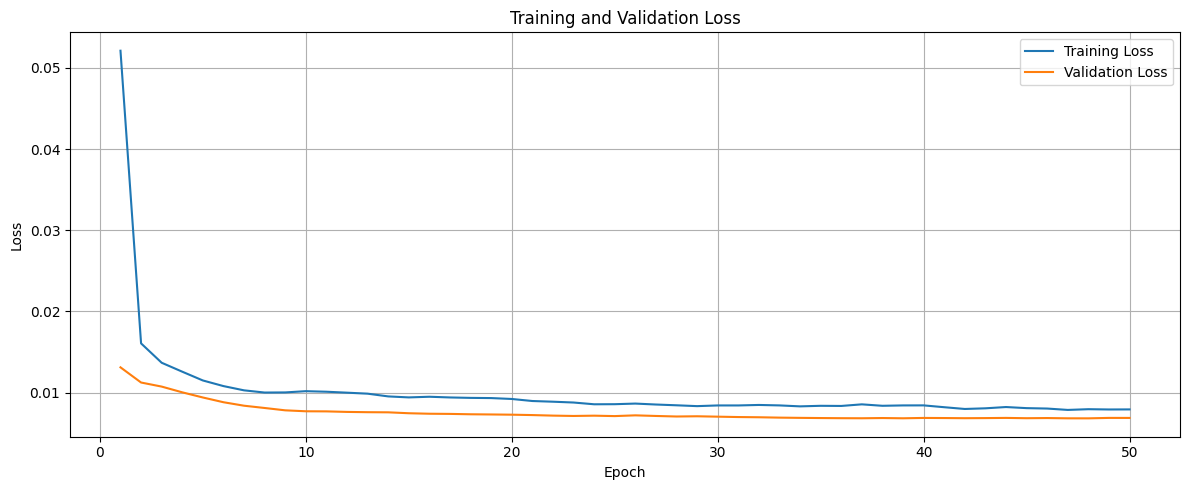

Model: "aod_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 16)        │        816 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 16)     │          0 │ dense_26[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_18… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 7, 18)     │      1,818 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,704 (1.34 MB)

 Trainable params: 117,234 (457.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,470 (915.90 KB)

None


Model: "aod_GRUSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,616 (232.88 KB)

 Trainable params: 59,616 (232.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_28[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_19    │ (None, 1, 64)     │          0 │ lstm_40[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_19… │
│                     │                   │            │ lstm_40[0][1],    │
│                     │                   │            │ lstm_40[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1, 64)     │          0 │ lstm_41[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 1, 1)      │         65 │ dropout_10[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None


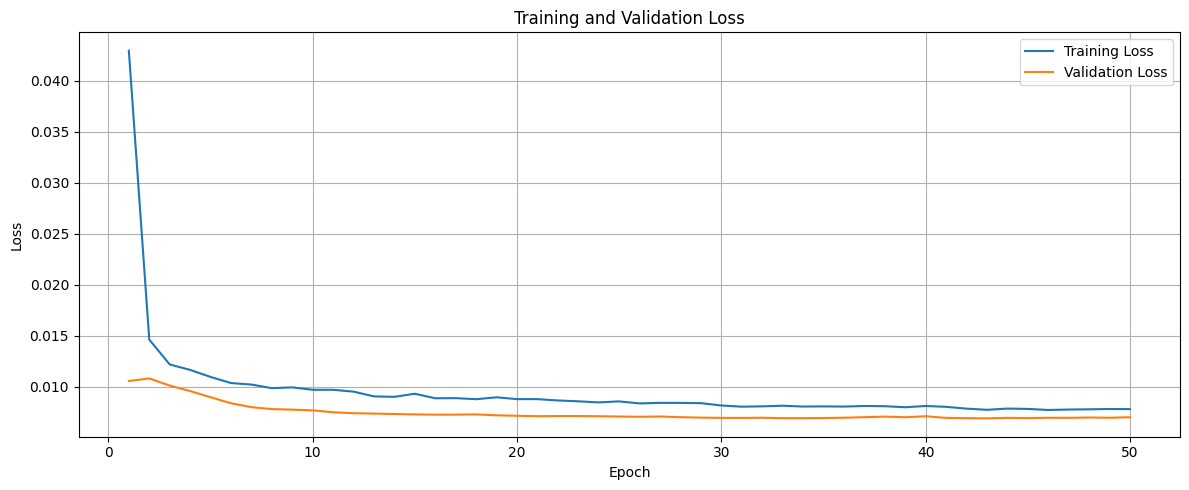

Model: "aod_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 17)        │        867 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 17)     │          0 │ dense_29[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_20… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 7, 18)     │      1,818 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,307 (1.34 MB)

 Trainable params: 117,435 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,872 (917.47 KB)

None


Model: "aod_GRUSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,667 (233.07 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_31[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_21    │ (None, 1, 64)     │          0 │ lstm_42[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_21… │
│                     │                   │            │ lstm_42[0][1],    │
│                     │                   │            │ lstm_42[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1, 64)     │          0 │ lstm_43[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 1)      │         65 │ dropout_11[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None


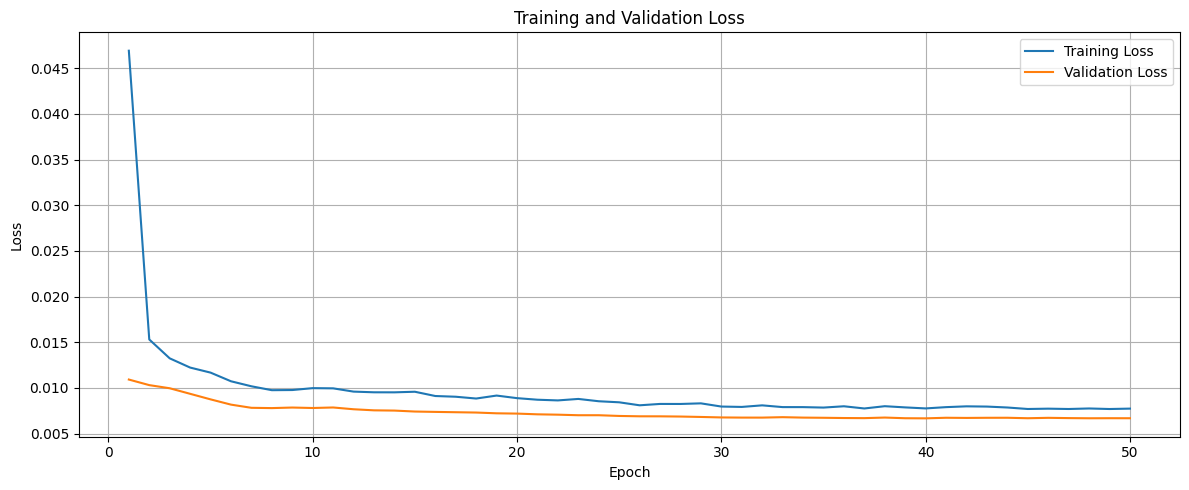

Choosing the best result

dict_keys([13, 14, 15, 16, 17])
N = 13
mae = 4.529875499593522
mse = 32.42424763318385
rmse = 5.694229327414189
r2 = -0.6844677027396564
mape = 0.23603638225512508
N = 14
mae = 4.195817998957404
mse = 29.849965369474283
rmse = 5.463512182605094
r2 = -0.6801872586285491
mape = 0.22955726007488086
N = 15
mae = 4.245053329436441
mse = 30.163658861050347
rmse = 5.492145196646785
r2 = -0.7334168532305809
mape = 0.23109099830998667
N = 16
mae = 4.252783180211174
mse = 30.131551070462667
rmse = 5.489221353749789
r2 = -0.5776768931286302
mape = 0.2298835124233862
N = 17
mae = 4.192645162829237
mse = 29.93437401464701
rmse = 5.471231489769648
r2 = -0.5096153792723099
mape = 0.22906047969668394


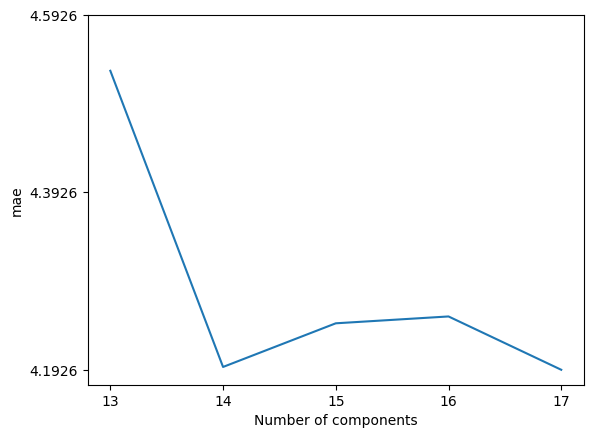

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


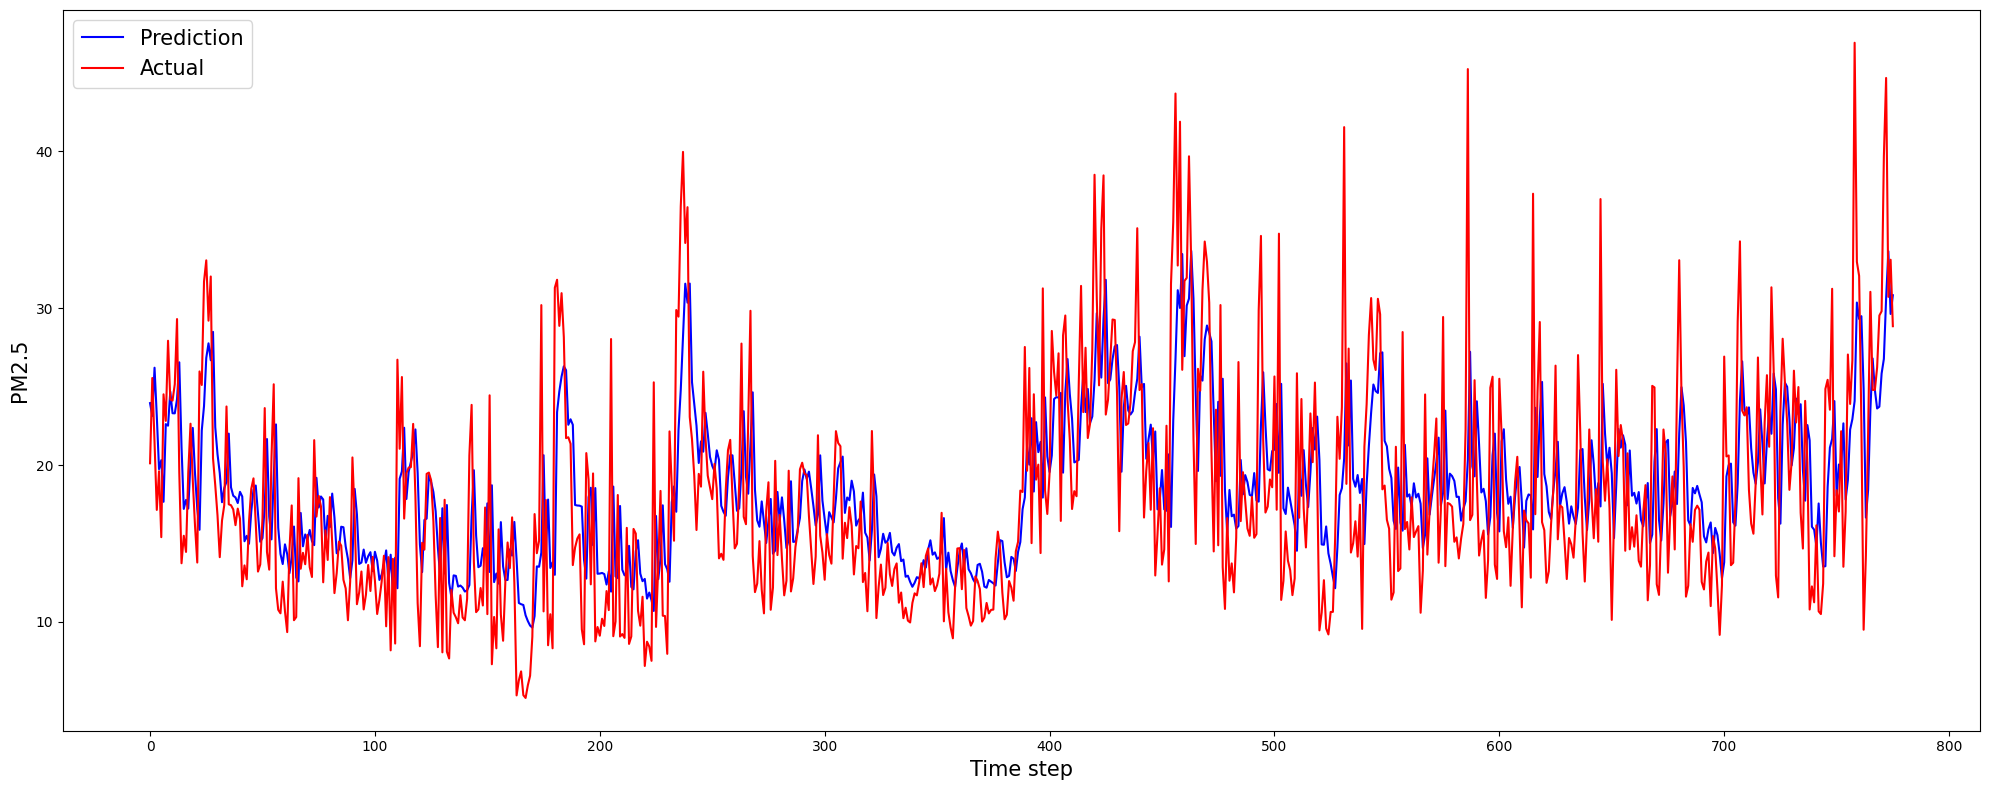

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  6.084257  51.476671   
1         LSTM-Seq2Seq                  15       LSTM  4.294261  32.141534   
2          GRU-Seq2Seq                  17       LSTM  4.192645  29.934374   

       rmse        r2      mape  
0  7.174724 -1.606329  0.281083  
1  5.669350 -1.846534  0.243456  
2  5.471231 -0.509615  0.229060

In [40]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, GRUSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [41]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.012867       0.026493       0.036503       0.116215   
2018-01-02       0.012867       0.026493       0.036503       0.116215   
2018-01-03       0.012647       0.026235       0.036299       0.116132   
2018-01-04       0.012183       0.025633       0.035693       0.116335   
2018-01-05       0.011912       0.025152       0.035143       0.115772   
...                   ...            ...            ...            ...   
2022-12-27       0.029557       0.022437       0.036196       0.057062   
2022-12-28       0.029496       0.022303       0.036114       0.056507   
2022-12-29       0.029585       0.022335       0.036091       0.056697   
2022-12-30       0.029672       0.022360       0.036202       0.057094   
2022-12-31       0.029608       0.022269       0.036238       0.057531   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.007429       0.007198       0.022027       0.013794   
2018-01-02       0.007429       0.007198       0.022027       0.013794   
2018-01-03       0.007320       0.007087       0.021797       0.013610   
2018-01-04       0.007050       0.006848       0.021371       0.013174   
2018-01-05       0.006839       0.006640       0.021033       0.012970   
...                   ...            ...            ...            ...   
2022-12-27       0.018854       0.018351       0.022074       0.045178   
2022-12-28       0.018721       0.018362       0.022011       0.045266   
2022-12-29       0.018847       0.018363       0.022033       0.045165   
2022-12-30       0.018880       0.018257       0.022159       0.044857   
2022-12-31       0.018804       0.018011       0.022130       0.044710   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.026915        0.027807        0.092067        0.434534   
2018-01-02       0.026915        0.027807        0.092067        0.434534   
2018-01-03       0.026611        0.027658        0.091551        0.438948   
2018-01-04       0.026004        0.027274        0.090636        0.447507   
2018-01-05       0.025402        0.027061        0.089950        0.453632   
...                   ...             ...             ...             ...   
2022-12-27       0.031194        0.074772        0.102599        0.262134   
2022-12-28       0.030977        0.074393        0.101969        0.265009   
2022-12-29       0.031135        0.074635        0.102446        0.262755   
2022-12-30       0.031392        0.074836        0.103924        0.258452   
2022-12-31       0.031332        0.074930        0.104778        0.257445   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.026607        0.029308        0.021698        0.035582   
2018-01-02        0.026607        0.029308        0.021698        0.035582   
2018-01-03        0.026288        0.028963        0.021350        0.035267   
2018-01-04        0.025604        0.028323        0.020672        0.034703   
2018-01-05        0.025220        0.027757        0.020287        0.034420   
...                    ...             ...             ...             ...   
2022-12-27        0.074135        0.030763        0.052352        0.057432   
2022-12-28        0.074383        0.030247        0.052403        0.057397   
2022-12-29        0.074262        0.030706        0.052636        0.057517   
2022-12-30        0.073859        0.031307        0.052920        0.057955   
2022-12-31        0.073540        0.031494        0.052797        0.057792   

            aod_feature_17  station  
time                           

In [42]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_grus2s_reduced_augmented = augmentReducedData(df_grus2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_grus2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_grus2s_reduced_augmented

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.012867       0.026493       0.036503       0.116215   
2018-01-02       0.012867       0.026493       0.036503       0.116215   
2018-01-03       0.012647       0.026235       0.036299       0.116132   
2018-01-04       0.012183       0.025633       0.035693       0.116335   
2018-01-05       0.011912       0.025152       0.035143       0.115772   
...                   ...            ...            ...            ...   
2022-12-27       0.029557       0.022437       0.036196       0.057062   
2022-12-28       0.029496       0.022303       0.036114       0.056507   
2022-12-29       0.029585       0.022335       0.036091       0.056697   
2022-12-30       0.029672       0.022360       0.036202       0.057094   
2022-12-31       0.029608       0.022269       0.036238       0.057531   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.007429       0.007198       0.022027       0.013794   
2018-01-02       0.007429       0.007198       0.022027       0.013794   
2018-01-03       0.007320       0.007087       0.021797       0.013610   
2018-01-04       0.007050       0.006848       0.021371       0.013174   
2018-01-05       0.006839       0.006640       0.021033       0.012970   
...                   ...            ...            ...            ...   
2022-12-27       0.018854       0.018351       0.022074       0.045178   
2022-12-28       0.018721       0.018362       0.022011       0.045266   
2022-12-29       0.018847       0.018363       0.022033       0.045165   
2022-12-30       0.018880       0.018257       0.022159       0.044857   
2022-12-31       0.018804       0.018011       0.022130       0.044710   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.026915        0.027807        0.092067        0.434534   
2018-01-02       0.026915        0.027807        0.092067        0.434534   
2018-01-03       0.026611        0.027658        0.091551        0.438948   
2018-01-04       0.026004        0.027274        0.090636        0.447507   
2018-01-05       0.025402        0.027061        0.089950        0.453632   
...                   ...             ...             ...             ...   
2022-12-27       0.031194        0.074772        0.102599        0.262134   
2022-12-28       0.030977        0.074393        0.101969        0.265009   
2022-12-29       0.031135        0.074635        0.102446        0.262755   
2022-12-30       0.031392        0.074836        0.103924        0.258452   
2022-12-31       0.031332        0.074930        0.104778        0.257445   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.026607        0.029308        0.021698        0.035582   
2018-01-02        0.026607        0.029308        0.021698        0.035582   
2018-01-03        0.026288        0.028963        0.021350        0.035267   
2018-01-04        0.025604        0.028323        0.020672        0.034703   
2018-01-05        0.025220        0.027757        0.020287        0.034420   
...                    ...             ...             ...             ...   
2022-12-27        0.074135        0.030763        0.052352        0.057432   
2022-12-28        0.074383        0.030247        0.052403        0.057397   
2022-12-29        0.074262        0.030706        0.052636        0.057517   
2022-12-30        0.073859        0.031307        0.052920        0.057955   
2022-12-31        0.073540        0.031494        0.052797        0.057792   

            aod_feature_17  station   pm25_3km  hiep_predicted_pm25  

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.192645162829237
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 29.93437401464701


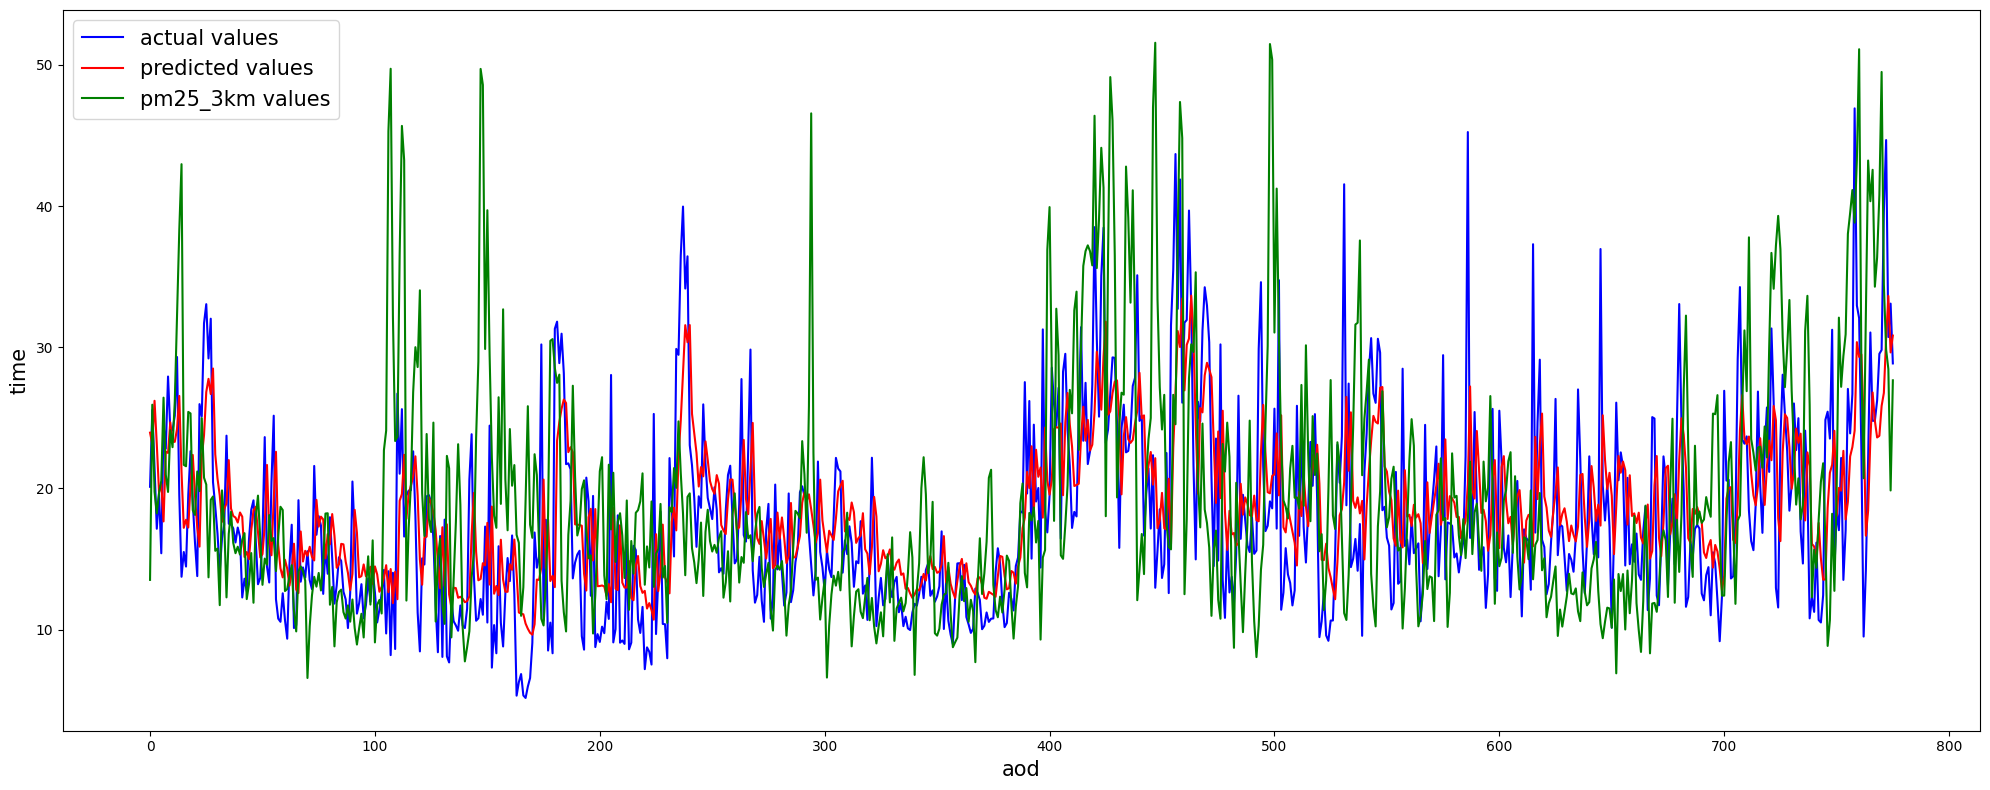

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.223588466644287


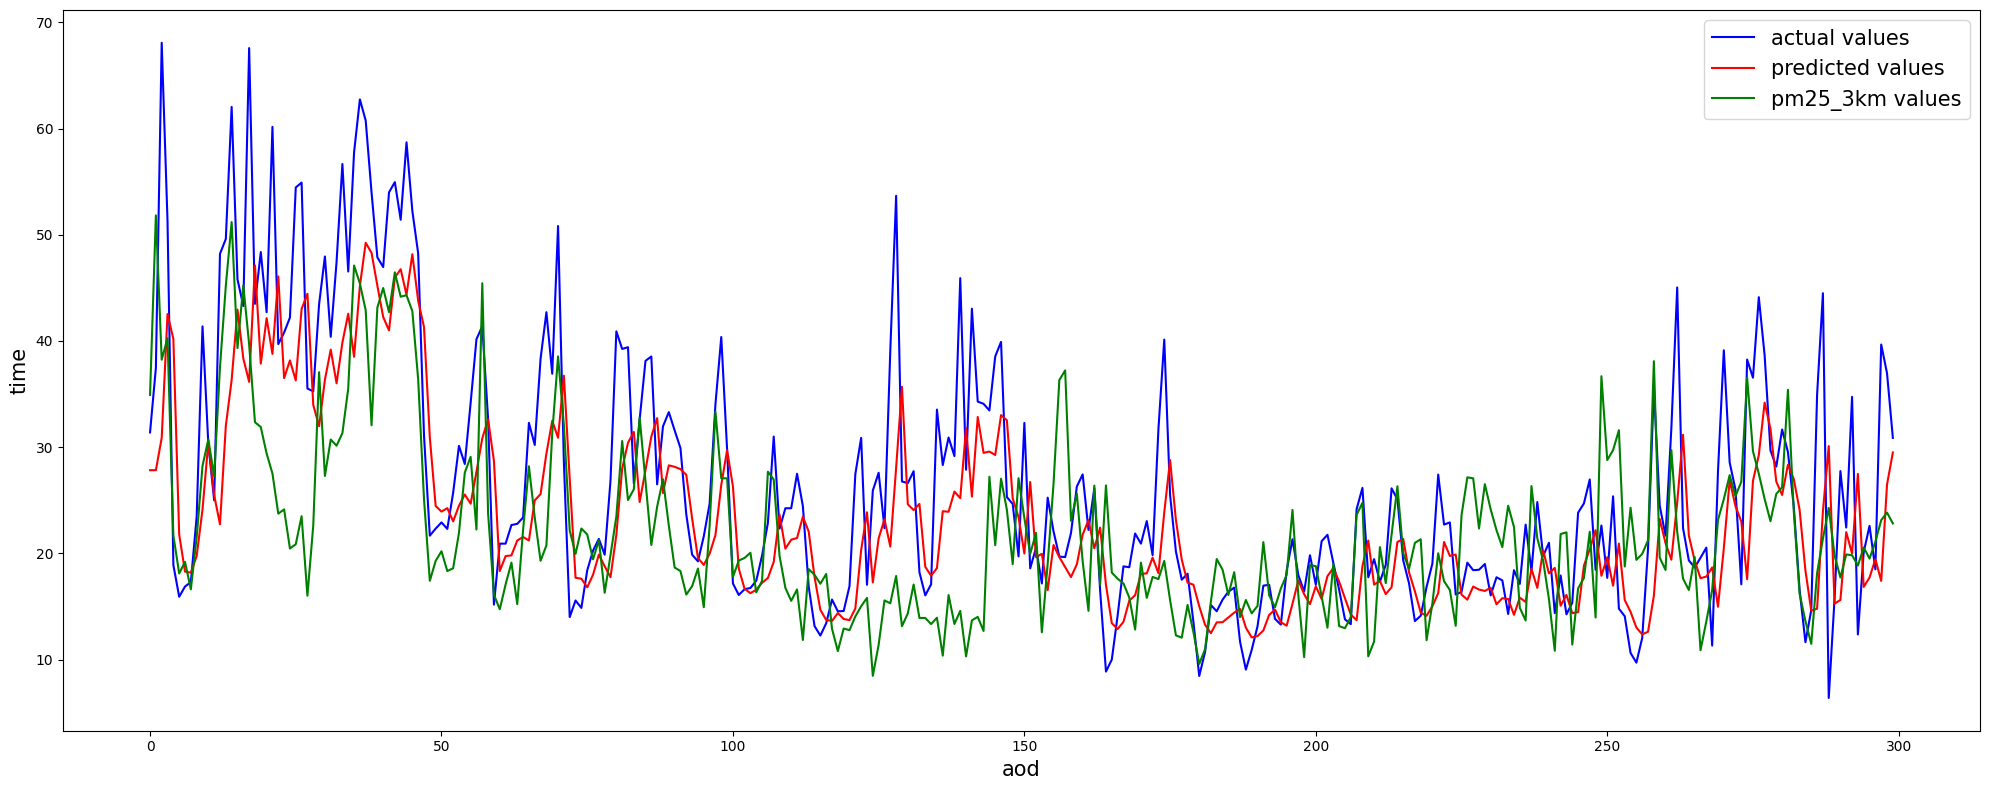

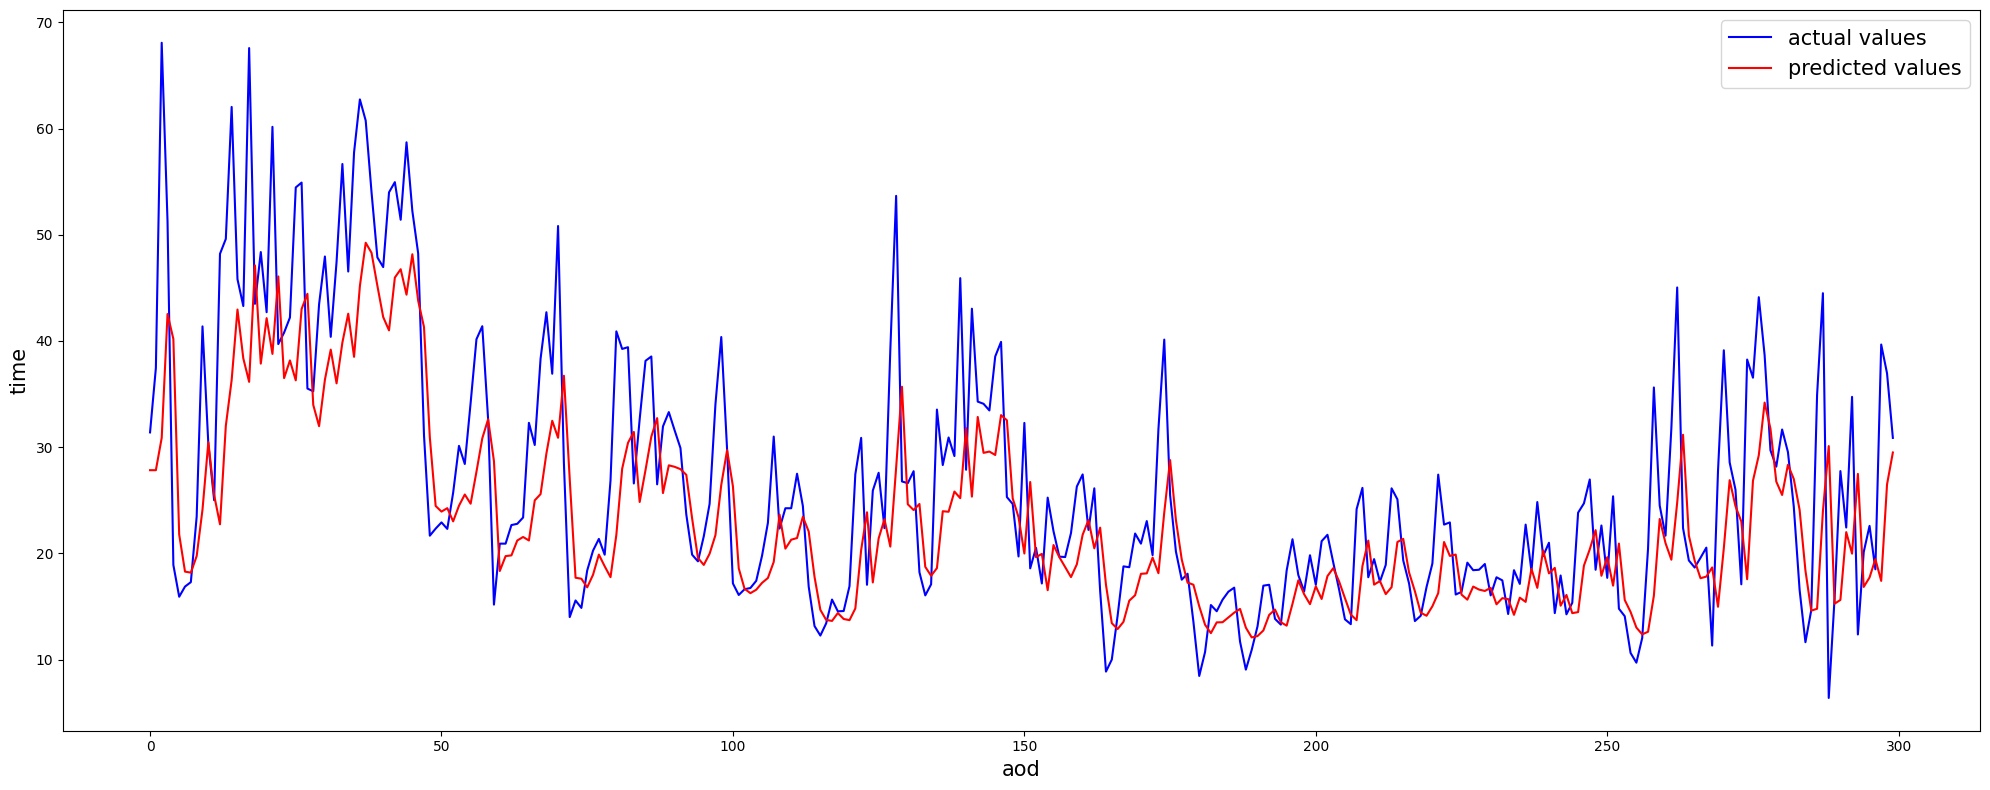

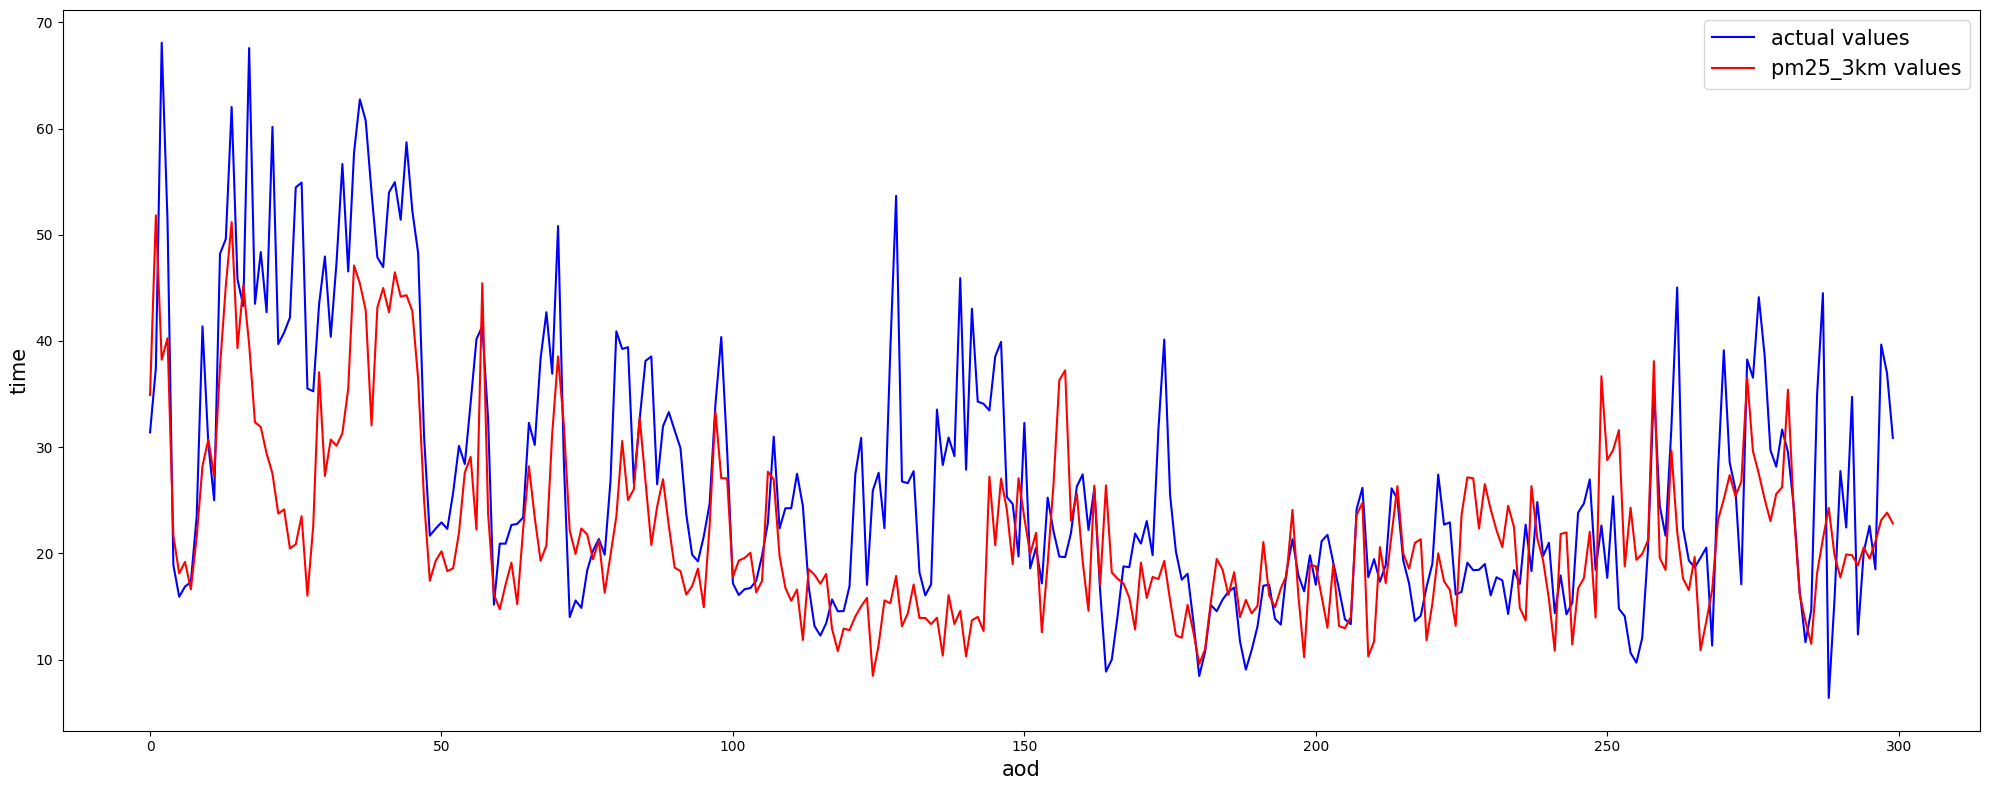

In [43]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_grus2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

#### Compare MAE with CMAQ pm25

[201 211 212 213 214 215 216]
[201 211 212 213 214 215 216]
[201 211 212 213 214 215 216]


station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2022-01-01      201  21.695652  10.783456  106.700622  22.705284  27.787918   
2022-01-02      201  24.583333  10.783456  106.700622  24.095436  24.707085   
2022-01-03      201  31.083333  10.783456  106.700622  45.302227  26.576595   
2022-01-04      201  50.916667  10.783456  106.700622  49.729404  26.506687   
2022-01-05      201  33.041667  10.783456  106.700622  32.204433  26.590250   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2022-01-01  61.073841  659.863586  1.885687  20680.62695  ...   
2022-01-02  65.996597  432.379822  1.432167  20680.62695  ...   
2022-01-03  66.171082  443.947327  1.533191  20680.62695  ...   
2022-01-04  76.320465  432.340332  1.721378  20680.62695  ...   
2022-01-05  79.178970  459.642944  1.762114  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2022-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2022-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2022-01-01  1876.639945  232011.95950    0.0  2700.122924  0.118424  
2022-01-02  1876.639945  232011.95950    0.0  2700.122924  0.484536  
2022-01-03  1876.639945  232011.95950    0.0  2700.122924  0.555172  
2022-01-04  1876.639945  232011.95950    0.0  2700.122924  0.726901  
2022-01-05  1876.639945  232011.95950    0.0  2700.122924  0.743757  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[998 rows x 21 columns]

hiep_predicted_pm25  station
time                                    
2022-01-01            19.324909      201
2022-01-02            20.442326      201
2022-01-03            22.439915      201
2022-01-04            25.571280      201
2022-01-05            33.643185      201
...                         ...      ...
2022-12-27            28.240995      216
2022-12-28            32.286633      216
2022-12-29            34.812592      216
2022-12-30            30.177010      216
2022-12-31            31.221661      216

[998 rows x 2 columns]

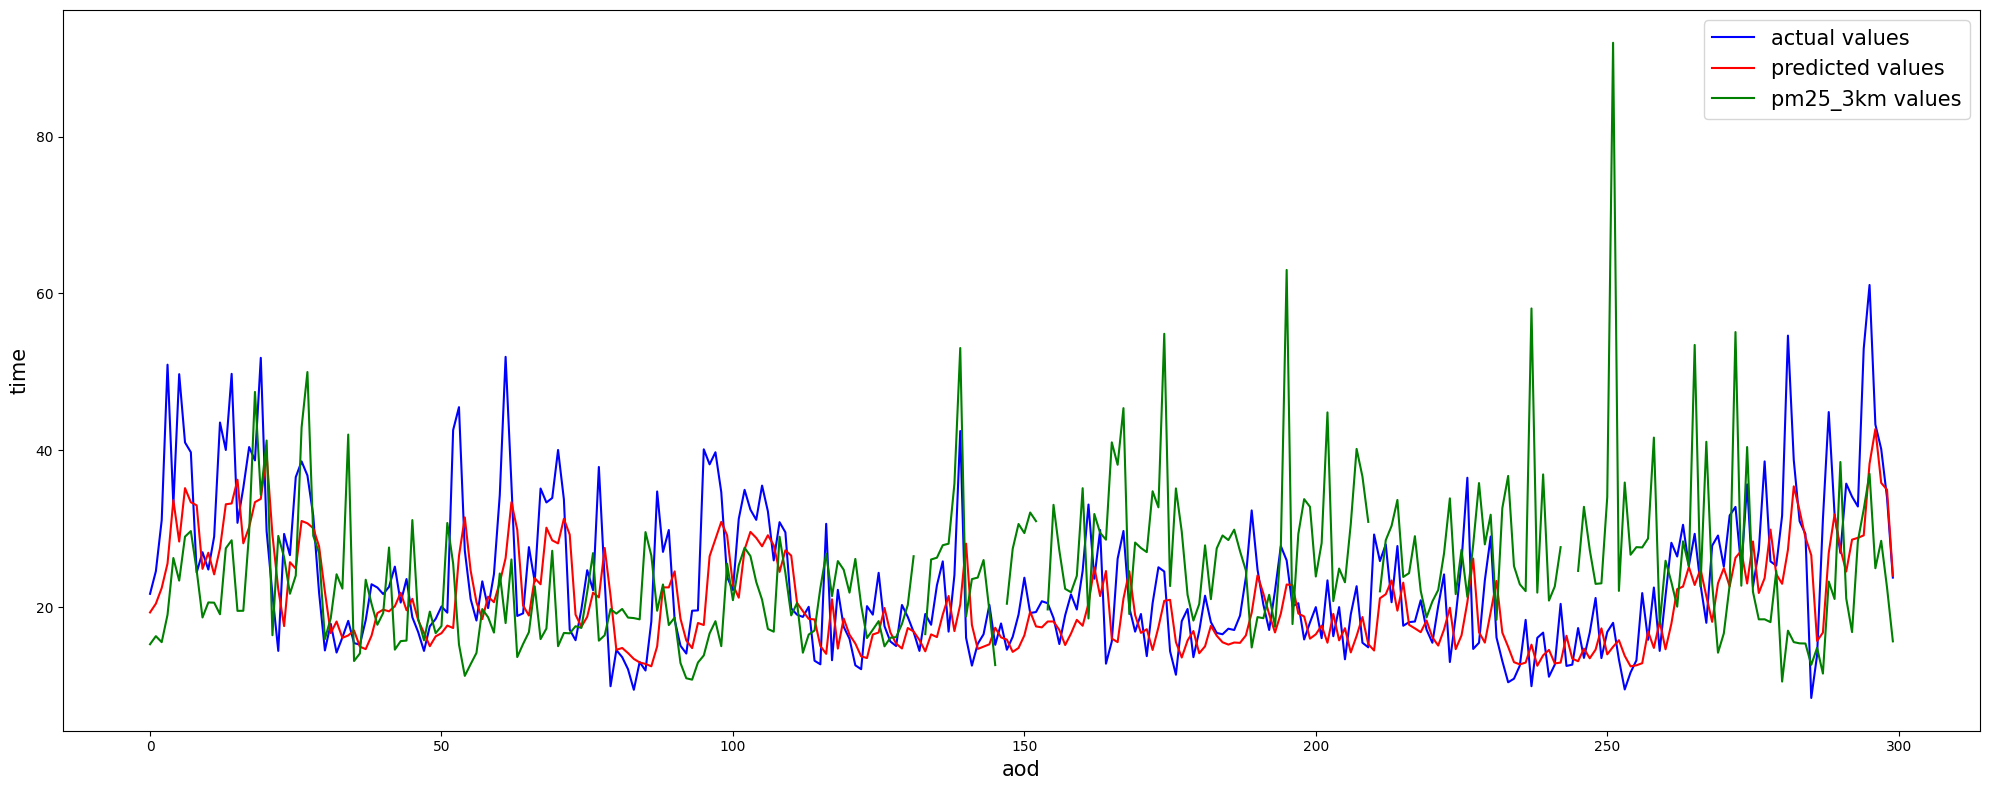

In [44]:
# Append pred all
df_pred_all = pd.concat([y_pred_all, aod_station_column], axis=1)
df_pred_all

# Remove station 202
df_pred_all_dropped_202 = df_pred_all[df_pred_all["station"] != 202]
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]

print(df_aod_dropped_202["station"].unique())
print(df_pred_all_dropped_202["station"].unique())
print(df_cmaq_daily["station"].unique())

time_mask = ((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))
df_aod_dropped_202 = df_aod_dropped_202.loc[time_mask]
display(df_aod_dropped_202)

time_mask = ((df_pred_all_dropped_202.index >= "2022-01-01") & (df_pred_all_dropped_202.index <= "2022-12-31"))
df_pred_all_dropped_202 = df_pred_all_dropped_202.loc[time_mask]
display(df_pred_all_dropped_202)

# Compare entire dataset
plot_3_data(data1=df_aod_dropped_202["pm25"].head(300),
           datalabel1="actual pm25 values",
           data2=df_pred_all_dropped_202["hiep_predicted_pm25"].head(300),
           datalabel2="predicted pm25 values",
           data3=df_cmaq_daily["pm25"].head(300),
           datalabel3="cmaq pm25 values",
           ylabel="time",
           xlabel="aod")

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


Model: "aod_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 24)     │      1,320 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 12)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_23    │ (None, 7, 12)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_23… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 13)        │        663 │ lstm_46[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 13)     │          0 │ dense_33[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_24… │
│                     │                   │            │ lstm_46[0][1],    │
│                     │                   │            │ lstm_46[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 7, 24)     │      1,224 │ lstm_47[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,801 (350.79 KB)

 Trainable params: 29,933 (116.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,868 (233.86 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_23 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,459 (60.39 KB)

 Trainable params: 15,459 (60.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_35[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_25    │ (None, 1, 64)     │          0 │ lstm_48[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_25… │
│                     │                   │            │ lstm_48[0][1],    │
│                     │                   │            │ lstm_48[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1, 64)     │          0 │ lstm_49[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 1, 1)      │         65 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None


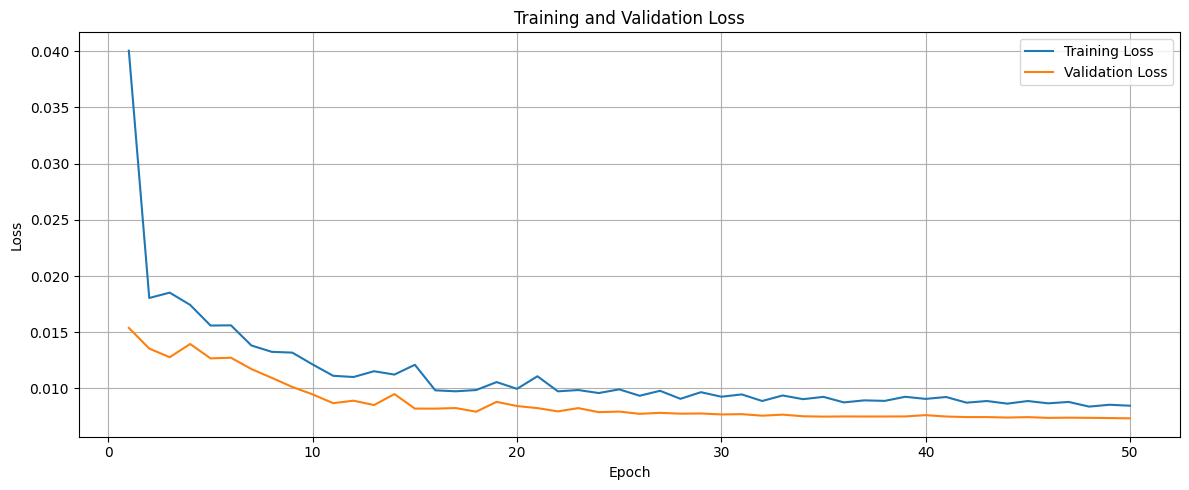

KeyboardInterrupt: 

In [45]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [ ]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

In [ ]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_cnnlstms2s_reduced_augmented = augmentReducedData(df_cnnlstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_cnnlstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_cnnlstms2s_reduced_augmented

#### Compare MAE with pm25_3km

In [ ]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_cnnlstms2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

#### Compare MAE with CMAQ pm25

In [ ]:
# Append pred all
df_pred_all = pd.concat([y_pred_all, aod_station_column], axis=1)
df_pred_all

# Remove station 202
df_pred_all_dropped_202 = df_pred_all[df_pred_all["station"] != 202]
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]

print(df_aod_dropped_202["station"].unique())
print(df_pred_all_dropped_202["station"].unique())
print(df_cmaq_daily["station"].unique())

time_mask = ((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))
df_aod_dropped_202 = df_aod_dropped_202.loc[time_mask]
display(df_aod_dropped_202)

time_mask = ((df_pred_all_dropped_202.index >= "2022-01-01") & (df_pred_all_dropped_202.index <= "2022-12-31"))
df_pred_all_dropped_202 = df_pred_all_dropped_202.loc[time_mask]
display(df_pred_all_dropped_202)

# Compare entire dataset
plot_3_data(data1=df_aod_dropped_202["pm25"].head(300),
           datalabel1="actual pm25 values",
           data2=df_pred_all_dropped_202["hiep_predicted_pm25"].head(300),
           datalabel2="predicted pm25 values",
           data3=df_cmaq_daily["pm25"].head(300),
           datalabel3="cmaq pm25 values",
           ylabel="time",
           xlabel="aod")